<a href="https://colab.research.google.com/github/AyusheeMittal/END_PythonCodeGenerationChatbot/blob/main/END_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import csv
import random
import re
import os
import math
import time
import unicodedata
import codecs
from io import open
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.jit import script, trace
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator,TabularDataset
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score

In [3]:
spacy_en = spacy.load('en')

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
!cp /content/drive/MyDrive/end/english_python_data_autopep2.txt .

In [6]:
conversations = []
with open('english_python_data_autopep2.txt', 'r') as datafile:
  for line in datafile.readlines():
      trimmed_line = line.rstrip()
      if trimmed_line: # Don't print blank lines
          #print(trimmed_line)
          conversations.append(trimmed_line)

qa_pairs = []
for i in range(len(conversations) - 3):
  inputLine = ''
  outputLine = ''
  if (conversations[i][0] == '#'):
    inputLine = conversations[i][2:]
    j = i+1
    targetLine = []
    while (conversations[j][0] != "#"):
      txt = conversations[j]
      txt = re.sub( r'([a-zA-Z])([,!({[+=*/=:<>)}])', r'\1 \2', txt)  # not done for single and double quotes and doing for dot gives improper value
      txt = re.sub( r'([,!({[+=*/=<>:)}])([a-zA-Z])', r'\1 \2', txt)  # adding space after punctuations
      txt = re.sub( r'([0-9])([,(=+*/%-)])', r'\1 \2', txt)
      txt = re.sub( r'([,=+*/%-])([0-9])', r'\1 \2', txt)
      targetLine.append(txt)
      j = j+1
    outputLine = ' \n'.join(targetLine)
    if(inputLine and outputLine and len(outputLine)<=300):
      qa_pairs.append([inputLine, outputLine])

In [7]:
qa_pairs[1]

['write a python function to add two user provided numbers and return the sum',
 'def add_two_numbers ( num1 , num2 ): \n    sum = num1 + num2 \n    return sum']

In [8]:
print(qa_pairs[1][1])

def add_two_numbers ( num1 , num2 ): 
    sum = num1 + num2 
    return sum


In [9]:
print(len(qa_pairs[1][1]))

75


In [10]:
clean_qa =[]
for item in qa_pairs:
  if len(item) == 2 :
    clean_qa.append(item)

In [11]:
clean_qa[1]

['write a python function to add two user provided numbers and return the sum',
 'def add_two_numbers ( num1 , num2 ): \n    sum = num1 + num2 \n    return sum']

In [12]:
processed_data_df = pd.DataFrame(clean_qa,columns=['src','trg'])
processed_data_df.to_csv('qa_data.csv',index = False)

In [13]:
processed_data_df.head(20)

,src,trg
0,write a python program to add two numbers,num1 = 1.5 \nnum2 = 6.3 \nsum = num1 + num2 \n...
1,write a python function to add two user provid...,"def add_two_numbers ( num1 , num2 ): \n sum..."
2,write a program to find and print the largest ...,num1 = 10 \nnum2 = 12 \nnum3 = 14 \nif ( num1 ...
3,write a program to find and print the smallest...,num1 = 10 \nnum2 = 12 \nnum3 = 14 \nif ( num1 ...
4,Write a python function to merge two given lis...,"def merge_lists ( l1 , l2 ): \n return l1 + l2"
5,Write a python function that prints the factor...,"def print_factors ( x ): \n print ( f""The fa..."
6,Write a program to find the factorial of a number,num = 13 \nfactorial = 1 \nif num < 0: \n pr...
7,Write a python function to print whether a num...,def check_pnz ( num ): \n if num > 0: \n ...
8,Write a program to print the multiplication ta...,"num = 9 \nfor i in range (1 , 11 ): \n print..."
9,"Write a python function to print powers of 2, ...",def two_power ( terms ): \n result = list (...


In [14]:
len(processed_data_df)

3764

In [15]:
processed_data_df['trg'][:5]

0    num1 = 1.5 \nnum2 = 6.3 \nsum = num1 + num2 \n...
1    def add_two_numbers ( num1 , num2 ): \n    sum...
2    num1 = 10 \nnum2 = 12 \nnum3 = 14 \nif ( num1 ...
3    num1 = 10 \nnum2 = 12 \nnum3 = 14 \nif ( num1 ...
4    def merge_lists ( l1 , l2 ): \n    return l1 + l2
Name: trg, dtype: object

In [16]:
txt = processed_data_df['trg'][11]
txt

'def sum_natural ( num ): \n    if num < 0: \n       print ("Please enter a positive number !") \n    else : \n       sum = 0 \n       while ( num > 0 ): \n           sum += num \n           num -= 1 \n       return num'

## Create Data Iterator

In [17]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [18]:
src = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

trg = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

fields = {'src' : ('src', src),
          'trg' : ('trg', trg)}

In [19]:
qa_data  = TabularDataset(
                            path = 'qa_data.csv',
                            format = 'csv',
                            fields = fields
                            )

In [20]:
train_data, valid_data, test_data = qa_data.split([0.7,.2,.1])

In [21]:
print(vars(train_data.examples[116]))

{'src': ['write', 'a', 'function', 'to', 'return', 'the', 'volume', 'of', 'a', 'cylinder'], 'trg': ['def', 'cal_cylinder_volume', '(', 'height', ',', 'radius', '):', '\n    ', 'pi', '=', '3.14', '\n    ', 'return', 'pi', '*', '(', 'radius', '*', '*', '2', ')', '*', 'height']}


In [22]:
print(vars(test_data.examples[1]))

{'src': ['write', 'a', 'function', 'to', 'remove', 'a', 'given', 'date', 'type', 'elements', 'from', 'a', 'list', '.'], 'trg': ['def', 'removedatatype', '(', 'li', ',', 'dtype', '):', '\n    ', 'res', '=', '[', ']', '\n    ', 'for', 'i', 'in', 'li', ':', '\n        ', 'if', 'not', 'isinstance', '(', 'i', ',', 'dtype', '):', '\n            ', 'res.append', '(', 'i', ')', '\n    ', 'return', 'res']}


In [23]:
import gensim
# WORD2VEC
W2V_SIZE = 768
W2V_WINDOW = 7
W2V_EPOCH = 100
W2V_MIN_COUNT = 1

# Collect corpus for training word embeddings
documents = [tokenize_en(x) for x in processed_data_df['src']]
documents = documents + [tokenize_en(x) for x in processed_data_df['trg']]

# Train Word Embeddings and save
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
w2v_model.save('embeddings.txt')

Vocab size 6430


In [24]:
documents

[['write', 'a', 'python', 'program', 'to', 'add', 'two', 'numbers'],
 ['write',
  'a',
  'python',
  'function',
  'to',
  'add',
  'two',
  'user',
  'provided',
  'numbers',
  'and',
  'return',
  'the',
  'sum'],
 ['write',
  'a',
  'program',
  'to',
  'find',
  'and',
  'print',
  'the',
  'largest',
  'among',
  'three',
  'numbers'],
 ['write',
  'a',
  'program',
  'to',
  'find',
  'and',
  'print',
  'the',
  'smallest',
  'among',
  'three',
  'numbers'],
 ['Write',
  'a',
  'python',
  'function',
  'to',
  'merge',
  'two',
  'given',
  'lists',
  'into',
  'one'],
 ['Write',
  'a',
  'python',
  'function',
  'that',
  'prints',
  'the',
  'factors',
  'of',
  'a',
  'given',
  'number'],
 ['Write',
  'a',
  'program',
  'to',
  'find',
  'the',
  'factorial',
  'of',
  'a',
  'number'],
 ['Write',
  'a',
  'python',
  'function',
  'to',
  'print',
  'whether',
  'a',
  'number',
  'is',
  'negative',
  ',',
  'positive',
  'or',
  'zero'],
 ['Write',
  'a',
  'program',

In [25]:
len(documents)

7528

In [26]:
words

dict_keys(['write', 'a', 'python', 'program', 'to', 'add', 'two', 'numbers', 'function', 'user', 'provided', 'and', 'return', 'the', 'sum', 'find', 'print', 'largest', 'among', 'three', 'smallest', 'Write', 'merge', 'given', 'lists', 'into', 'one', 'that', 'prints', 'factors', 'of', 'number', 'factorial', 'whether', 'is', 'negative', ',', 'positive', 'or', 'zero', 'multiplication', 'table', 'powers', '2', 'for', 'terms', 'filter', 'in', 'list', 'which', 'are', 'divisible', 'by', 'returns', 'n', 'natural', 'swap', 'first', 'last', 'elements', 'area', 'circle', 'whose', 'radius', 'squares', 'length', 'pythno', 'tuple', 'element', 'line', 'remove', 'all', 'odd', 'from', 'remaining', 'even', 'takes', 'as', 'input', 'zipped', 'corresponding', 'contents', 'file', 'functin', 'LCM', 'unique', 'digits', 'check', 'palindrome', 'not', 'value', 'times', 'sqaure', 'perimeter', 'square', 'rectangle', 'permieter', 'calculate', 'electricity', 'bill', '.', 'Units', 'used', 'Price', 'per', 'unit', 'fixe

In [27]:
w2v_model.wv.vocab

{'write': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1550>,
 'a': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1650>,
 'python': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1690>,
 'program': <gensim.models.keyedvectors.Vocab at 0x7fbae39c16d0>,
 'to': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1750>,
 'add': <gensim.models.keyedvectors.Vocab at 0x7fbae39c17d0>,
 'two': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1810>,
 'numbers': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1850>,
 'function': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1710>,
 'user': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1790>,
 'provided': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1890>,
 'and': <gensim.models.keyedvectors.Vocab at 0x7fbae39c18d0>,
 'return': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1910>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1950>,
 'sum': <gensim.models.keyedvectors.Vocab at 0x7fbae39c1990>,
 'find': <gensim.models.keyedvectors.Vocab at 

In [28]:
src.build_vocab(train_data, min_freq = 2)
trg.build_vocab(train_data, min_freq = 1)

In [29]:
len(src.vocab)

1221

In [30]:
len(trg.vocab)

4103

In [31]:
w2v_model = gensim.models.word2vec.Word2Vec.load('embeddings.txt')

In [32]:
word2vec_src = []
word2vec_trg = []
for token, idx in tqdm_notebook(src.vocab.stoi.items()):
    if token in w2v_model.wv.vocab.keys():
        word2vec_src.append(torch.FloatTensor(w2v_model[token]))
    else:
        word2vec_src.append(torch.zeros(W2V_SIZE))
src.vocab.set_vectors(src.vocab.stoi, word2vec_src, W2V_SIZE)

for token, idx in tqdm_notebook(trg.vocab.stoi.items()):
    if token in w2v_model.wv.vocab.keys():
        word2vec_trg.append(torch.FloatTensor(w2v_model[token]))
    else:
        word2vec_trg.append(torch.zeros(W2V_SIZE))
trg.vocab.set_vectors(trg.vocab.stoi, word2vec_trg, W2V_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [33]:
pre_trained_emb_src = torch.FloatTensor(src.vocab.vectors)
embedding_src = nn.Embedding.from_pretrained(pre_trained_emb_src)

In [34]:
embedding_src

Embedding(1221, 768)

In [35]:
pre_trained_emb_trg = torch.FloatTensor(trg.vocab.vectors)
embedding_trg = nn.Embedding.from_pretrained(pre_trained_emb_trg)

In [36]:
embedding_trg

Embedding(4103, 768)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device,
     sort_within_batch = True,
     sort_key = lambda x: len(x.src))

cuda


In [38]:
#all_stopwords = spacy_en.Defaults.stop_words
#all_stopwords

## Create Model

In [39]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 embedding_src,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = embedding_src #nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [40]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [41]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [42]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [43]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 embedding_trg,
                 max_length = 150):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = embedding_trg  #nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [44]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [45]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #print(trg_pad_mask.shape, trg_pad_mask)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #print(trg_mask.sum())
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Train and Evaluate the Model

In [46]:
INPUT_DIM = len(src.vocab)
OUTPUT_DIM = len(trg.vocab)
HID_DIM = 768
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device, 
              embedding_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              embedding_trg)

In [47]:
SRC_PAD_IDX = src.vocab.stoi[src.pad_token]
TRG_PAD_IDX = trg.vocab.stoi[trg.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [48]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,835,399 trainable parameters


In [49]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [50]:
model.apply(initialize_weights);

In [51]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [52]:
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [53]:
# smoothing_eps = 0.1
# Taken from https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/train.py#L38

def cal_performance(pred, gold, trg_pad_idx=TRG_PAD_IDX, smoothing=True):
    ''' Apply label smoothing if needed '''

    loss = cal_loss(pred, gold, trg_pad_idx=TRG_PAD_IDX, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word

def cal_loss(pred, gold, trg_pad_idx=TRG_PAD_IDX, smoothing=True):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1 
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        
        div_size = loss.size(0)
        # print("Pred size: ", n_class)
        # print("loss shape:", loss.shape)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
        # print("loss sum shape:", loss.shape)
        loss = loss / div_size
    else:
        # loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='mean')
    return loss

In [54]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
# loss = cal_loss(output, trg, TRG_PAD_IDX, smoothing=True)
# criterion = cal_loss
criterion = cal_performance

In [55]:
def evaluate_model(model, iterator):
    all_preds = []
    all_y = []
    for idx,batch in enumerate(iterator):
        if torch.cuda.is_available():
            x = batch.text.cuda()
        else:
            x = batch.src
        y_pred = model(x)
        predicted = torch.max(y_pred.cpu().data, 1)[1] + 1
        all_preds.extend(predicted.numpy())
        all_y.extend(batch.trg.numpy())
    score = accuracy_score(all_y, np.array(all_preds).flatten())
    return score

#### **Training Function**

In [56]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    epoch_word_total = 0
    epoch_word_correct = 0
    epoch_acc = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        # print("Src shape:", src.shape)
        # print("Trg shape:", trg.shape)

        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss, n_correct, n_word = criterion(output, trg)
        # loss = cal_loss(output, trg, TRG_PAD_IDX, smoothing=True)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_word_total += n_word
        epoch_word_correct += n_correct
    
    epoch_acc = epoch_word_correct / epoch_word_total
        
    return epoch_loss / len(iterator), epoch_acc

#### **Test Function**

In [57]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    epoch_word_total = 0
    epoch_word_correct = 0
    epoch_acc = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss, n_correct, n_word = criterion(output, trg)
            # loss = cal_loss(output, trg, TRG_PAD_IDX, smoothing=True)

            epoch_loss += loss.item()
            epoch_word_total += n_word
            epoch_word_correct += n_correct
        
    epoch_acc = epoch_word_correct / epoch_word_total

    return epoch_loss / len(iterator), epoch_acc

### **Run Training Loop**

In [58]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [59]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train Acc: {train_acc: .3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Valid Acc: {valid_acc: .3f}')
    # print(f'\tTrain Loss: {train_loss:.3f} ')
    # print(f'\t Val. Loss: {valid_loss:.3f} ')

Epoch: 01 | Time: 0m 5s
	Train Loss: 2.370 | Train PPL:  10.702 | Train Acc:  0.114
	 Val. Loss: 2.090 |  Val. PPL:   8.084 | Valid Acc:  0.233
Epoch: 02 | Time: 0m 5s
	Train Loss: 1.896 | Train PPL:   6.661 | Train Acc:  0.280
	 Val. Loss: 1.771 |  Val. PPL:   5.878 | Valid Acc:  0.339
Epoch: 03 | Time: 0m 5s
	Train Loss: 1.682 | Train PPL:   5.376 | Train Acc:  0.349
	 Val. Loss: 1.642 |  Val. PPL:   5.164 | Valid Acc:  0.382
Epoch: 04 | Time: 0m 5s
	Train Loss: 1.553 | Train PPL:   4.725 | Train Acc:  0.394
	 Val. Loss: 1.554 |  Val. PPL:   4.732 | Valid Acc:  0.419
Epoch: 05 | Time: 0m 5s
	Train Loss: 1.456 | Train PPL:   4.288 | Train Acc:  0.429
	 Val. Loss: 1.473 |  Val. PPL:   4.363 | Valid Acc:  0.453
Epoch: 06 | Time: 0m 5s
	Train Loss: 1.357 | Train PPL:   3.885 | Train Acc:  0.464
	 Val. Loss: 1.423 |  Val. PPL:   4.150 | Valid Acc:  0.471
Epoch: 07 | Time: 0m 5s
	Train Loss: 1.291 | Train PPL:   3.636 | Train Acc:  0.488
	 Val. Loss: 1.376 |  Val. PPL:   3.960 | Valid Acc:

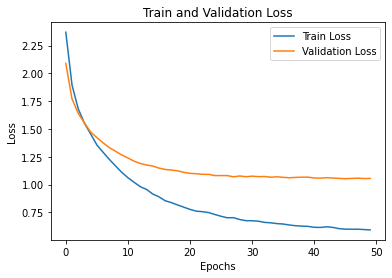

In [60]:
from matplotlib import pyplot as plt
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

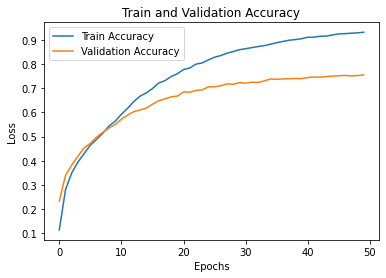

In [61]:
# Rough estimate of accuracy, just checking presence of correct words among predicted words
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(valid_acc_list, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
print(train_loss_list)

[2.3704478854224798, 1.896313814889817, 1.6820007846468972, 1.5527958188738142, 1.455773529552278, 1.3571117491949172, 1.2909739159402394, 1.2274338546253385, 1.1685092505954562, 1.1108593628520058, 1.0619860121182032, 1.0206457773844402, 0.9812578615688142, 0.9565535216104417, 0.9154622498012724, 0.8900177223341805, 0.8549070415042695, 0.8379802533558437, 0.8171856687182472, 0.796978235244751, 0.7770496578443618, 0.7610742421377272, 0.7566120567775908, 0.7484174711363656, 0.7311526338259379, 0.7151408819925218, 0.7015905635697501, 0.7024296351841518, 0.6859884460767111, 0.6755513265019372, 0.6750311652819315, 0.6709024366878328, 0.6603198108218965, 0.6563943369047982, 0.6492569815544855, 0.6454541967028663, 0.6366778328305199, 0.6301089354923793, 0.6266339705103919, 0.6240871066138858, 0.6162386054084414, 0.6146790924526396, 0.6206632114592052, 0.6150405080545516, 0.6041072493507749, 0.5991912058421544, 0.5985755012148902, 0.5989534783931005, 0.5959107492651258, 0.5924614298911322]


In [64]:
#model.load_state_dict(torch.load('tut6-model.pt'))
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Test Acc: {test_acc: .3f}')


| Test Loss: 0.997 | Test PPL:   2.711 | Test Acc:  0.756


## Chatbot using Trained Model

In [65]:
def generate_words(sentence, sentence_field, code_field, model, device,max_length=100):
  model.eval()

  tokens = [token.lower() for token in tokenize_en(sentence)]
  print(tokens)

  tokens = [sentence_field.init_token] + tokens + [sentence_field.eos_token]
  src_indexes = [sentence_field.vocab.stoi[token] for token in tokens]
  src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
  src_mask = model.make_src_mask(src_tensor)

  with torch.no_grad():
      enc_src = model.encoder(src_tensor, src_mask)

  trg_indexes = [sentence_field.vocab.stoi[sentence_field.init_token]]

  for i in range(max_length):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        #print("output", output)
        pred_token = output.argmax(2)[:,-1].item()
        #print("pred_token", pred_token)
        trg_indexes.append(pred_token)

        if pred_token == sentence_field.vocab.stoi[sentence_field.eos_token]:
            break
    
  trg_tokens = [code_field.vocab.itos[i] for i in trg_indexes]
  return trg_tokens[1:], attention

In [67]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(10,20))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [68]:
example_idx = 88

src1 = vars(train_data.examples[example_idx])['src']
trg1 = vars(train_data.examples[example_idx])['trg']

print(f'src = {src1}')
print(f'trg = {trg1}')

src = ['write', 'a', 'python', 'program', 'to', 'remove', 'the', 'characters', 'of', 'odd', 'index', 'values', 'in', 'a', 'string']
trg = ['def', 'modify', '(', 'string', '):', '\n    ', 'final', '=', '"', '"', '\n    ', 'for', 'i', 'in', 'range', '(', 'len', '(', 'string', ')', '):', '\n        ', 'if', 'i', '%', '2', '=', '=', '0', ':', '\n            ', 'final', '=', 'final', '+', 'string', '[', 'i', ']', '\n    ', 'return', 'final']


In [69]:
def chatbot(sentence_field, target_field, model, device):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            
            # Evaluate sentence
            output_words, _ = generate_words(input_sentence, sentence_field, target_field, model, device,max_length=250)
            # print(output_words)

            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == '<eos>' or x == '<pad>' or x == '<unk>')]
            print('Bot:\n', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [70]:
model.load_state_dict(torch.load('model.pt'))

chatbot(src, trg, model, device)

> Add two numbers
['add', 'two', 'numbers']
Bot:
 num1 = 1.5 
 num2 = 6.3 
 sum = num1 + num2 
 print ( f'sum : { sum } ' )
> write a function to add two numbers
['write', 'a', 'function', 'to', 'add', 'two', 'numbers']
Bot:
 def add_two_numbers ( num1 , num2 ): 
     sum = num1 + num2 
     return sum
> Write a function to multiply two numbers
['write', 'a', 'function', 'to', 'multiply', 'two', 'numbers']
Bot:
 def mul_two_numbers ( num1 , num2 ): 
     mul = num1 * num2 
     return mul
> Write a function to return the sum of the digits of a given number
['write', 'a', 'function', 'to', 'return', 'the', 'sum', 'of', 'the', 'digits', 'of', 'a', 'given', 'number']
Bot:
 def sum_of_digits ( num ): 
     sum = 0 
     while ( num > 0 ): 
         sum + = num % 10 
         num = num // 10 
     return sum
> Display the date and time
['display', 'the', 'date', 'and', 'time']
Bot:
 import datetime 
 now = datetime.datetime.now ( ) 
 time = now.strftime ( " % y-%m-%d % h : % m : % s " ) 
 p

### **Attention graph and metric functions**

In [71]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

### **25 Examples from code**

In [72]:
# Asking the model to 'write a function' gives better results, since our dataset questions are of this form

inference_questions = [
    'Add two numbers',
    'write a function to add two numbers',
    'Write a function to multiply two numbers',
    'Write a function to return the sum of the digits of a given number',                       
    'Display the date and time',
    'Write a function to reverse a list',
    'Write a function to find the factorial of n',
    'Check if the number is a perfect square',
    'Find a number in the list that does not occur twice',
    'Write a function to print the current time in milliseconds',
    'write a function to print a matrix as output',
    'Print a sentence into lower case',
    'write a function to add two matrices',
    'write a program to count number of cpu cores available',
    'write a python function to flatten nested lists', 
    'remove integer from string in python',
    'write a python function to find the median on an array of numbers',
    'Write a Python function to check if a given string is an anagram of another given string',
    'Check if a string is a palindrome or not',
    'Write a function to find the fibonacci series of n',
    'Write a function to calculate the area of a circle',
    'Write a Python program to find the smallest multiple of the first n numbers',
    'Write a Python function to find the maximum EVEN number from a given list',
    'Write a python function to convert a string to upper case',
    'Write a Python program to print current time in milliseconds'
]


*****************************************************************
['add', 'two', 'numbers']
Add two numbers
*****************************************************************
 num1 = 1.5 
 num2 = 6.3 
 sum = num1 + num2 
 print ( f'sum : { sum } ' )


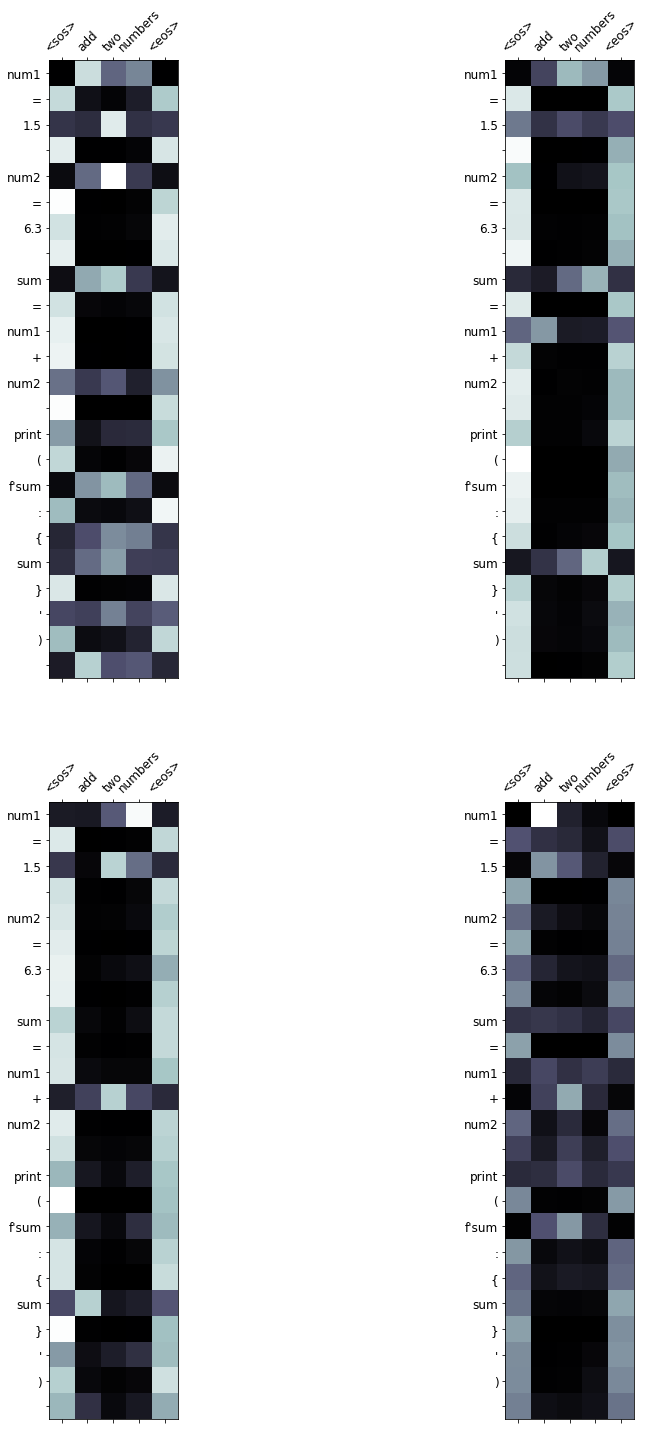


*****************************************************************
['write', 'a', 'function', 'to', 'add', 'two', 'numbers']
write a function to add two numbers
*****************************************************************
 def add_two_numbers ( num1 , num2 ): 
     sum = num1 + num2 
     return sum


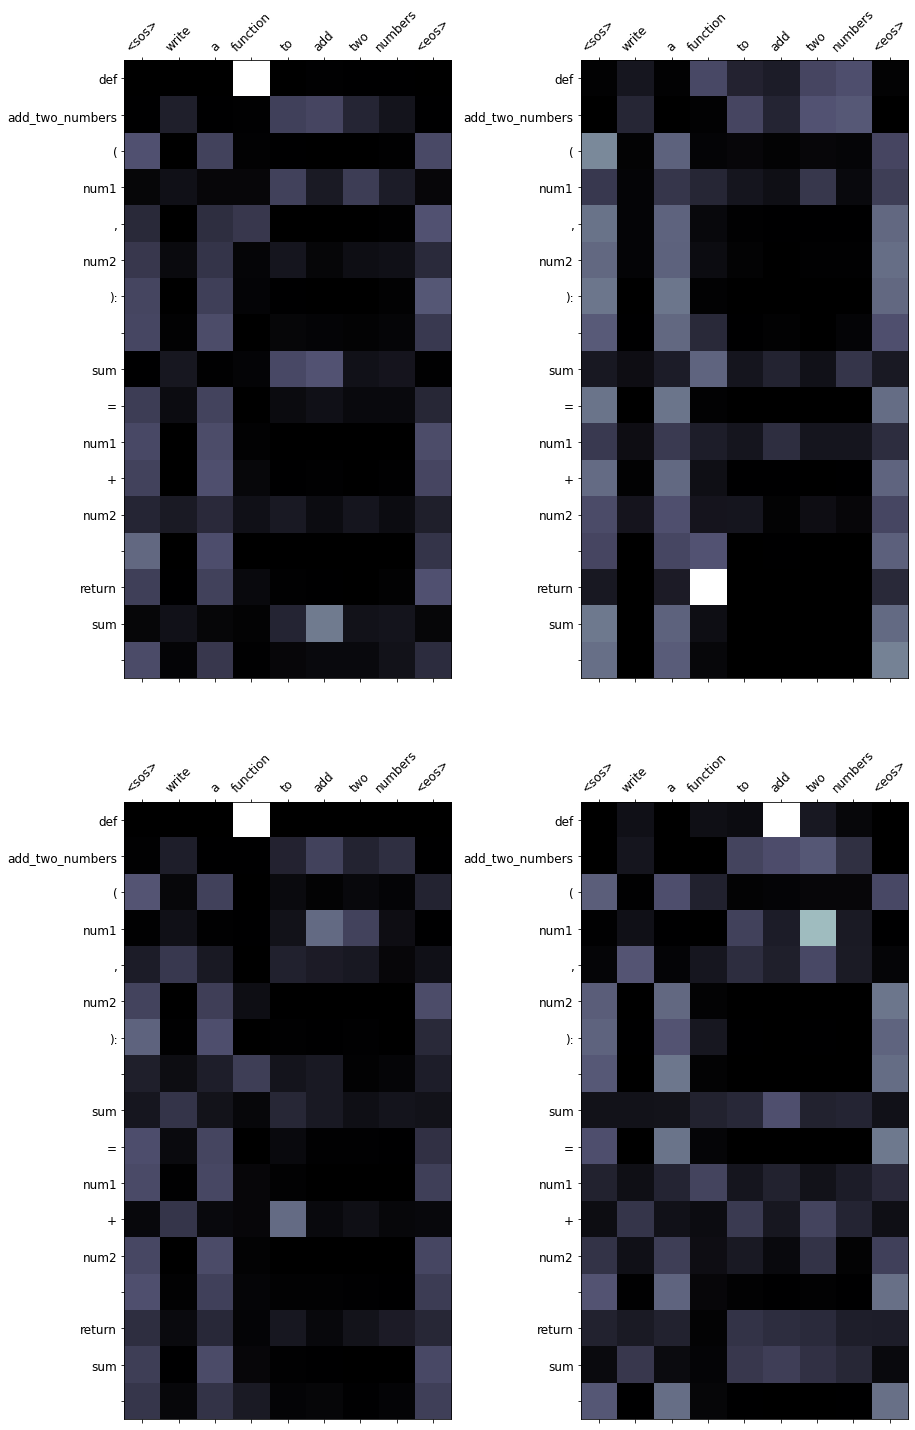


*****************************************************************
['write', 'a', 'function', 'to', 'multiply', 'two', 'numbers']
Write a function to multiply two numbers
*****************************************************************
 def mul_two_numbers ( num1 , num2 ): 
     mul = num1 * num2 
     return mul


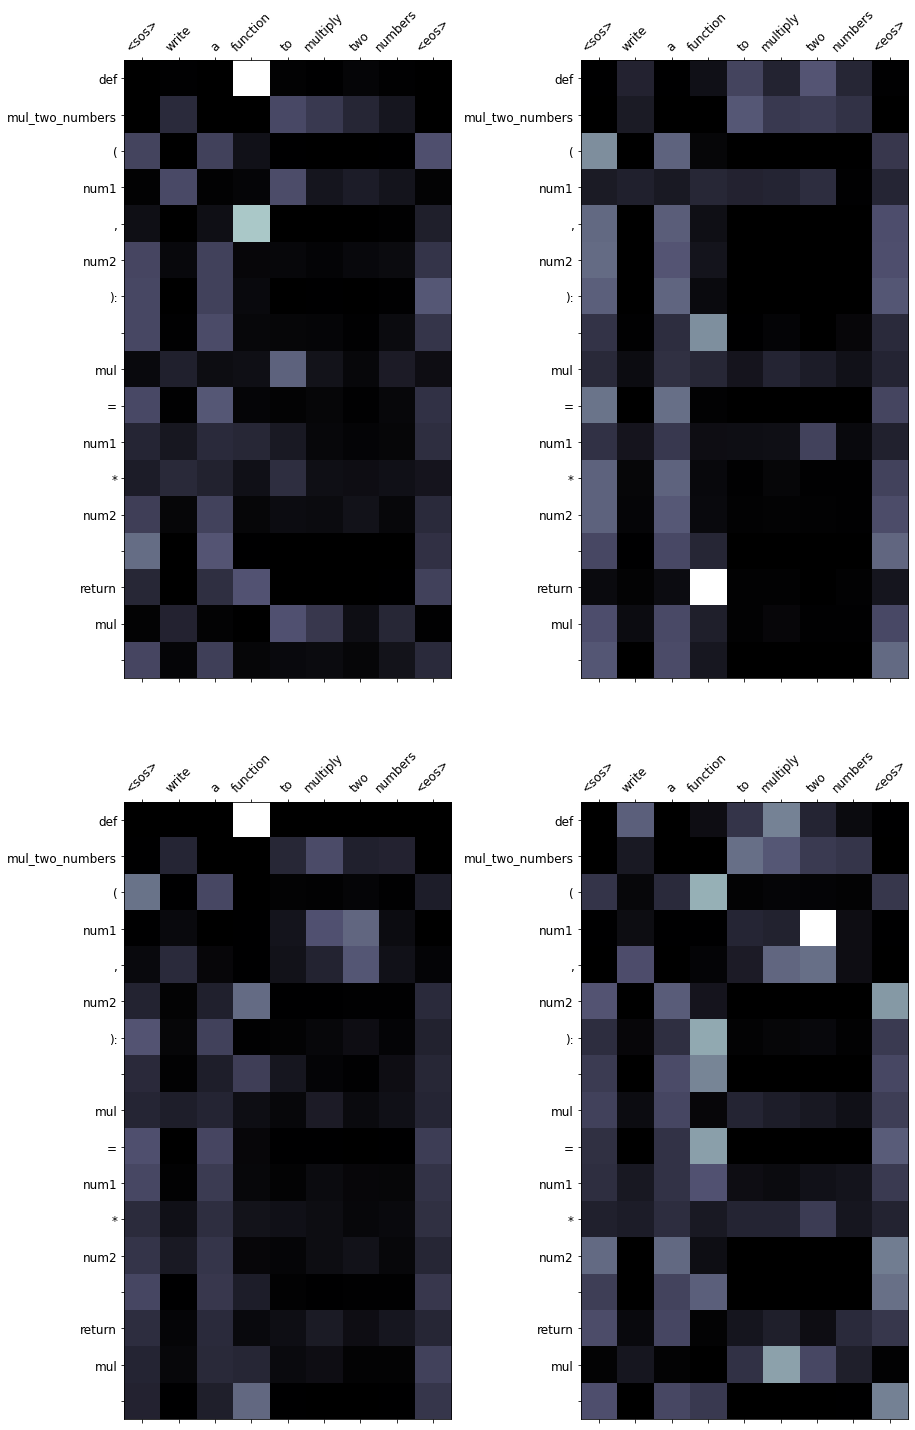


*****************************************************************
['write', 'a', 'function', 'to', 'return', 'the', 'sum', 'of', 'the', 'digits', 'of', 'a', 'given', 'number']
Write a function to return the sum of the digits of a given number
*****************************************************************
 def sum_of_digits ( num ): 
     sum = 0 
     while ( num > 0 ): 
         sum + = num % 10 
         num = num // 10 
     return sum


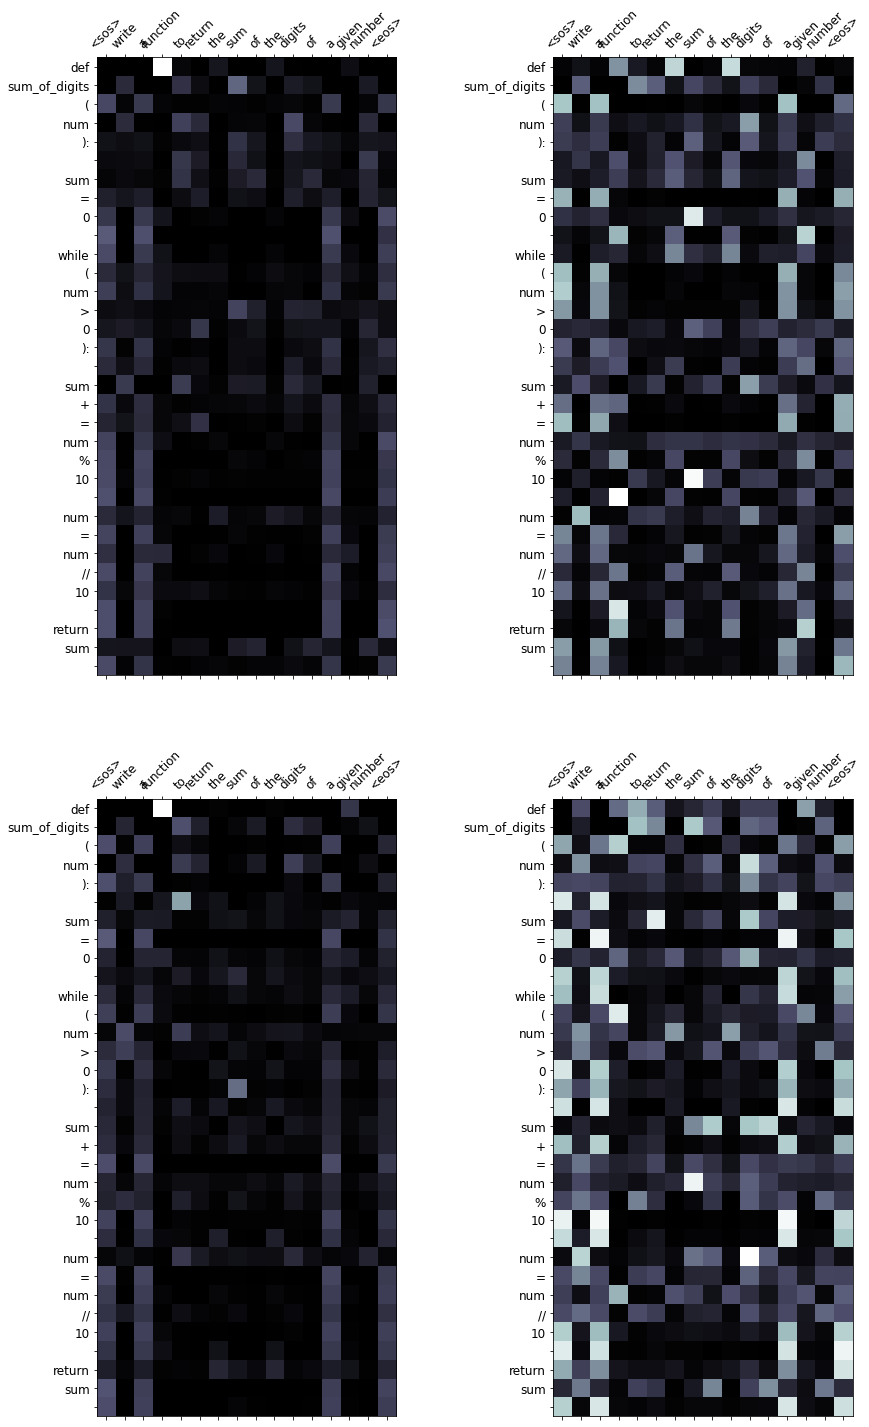


*****************************************************************
['display', 'the', 'date', 'and', 'time']
Display the date and time
*****************************************************************
 import datetime 
 now = datetime.datetime.now ( ) 
 time = now.strftime ( " % y-%m-%d % h : % m : % s " ) 
 print ( f"current date and time : { time } ")


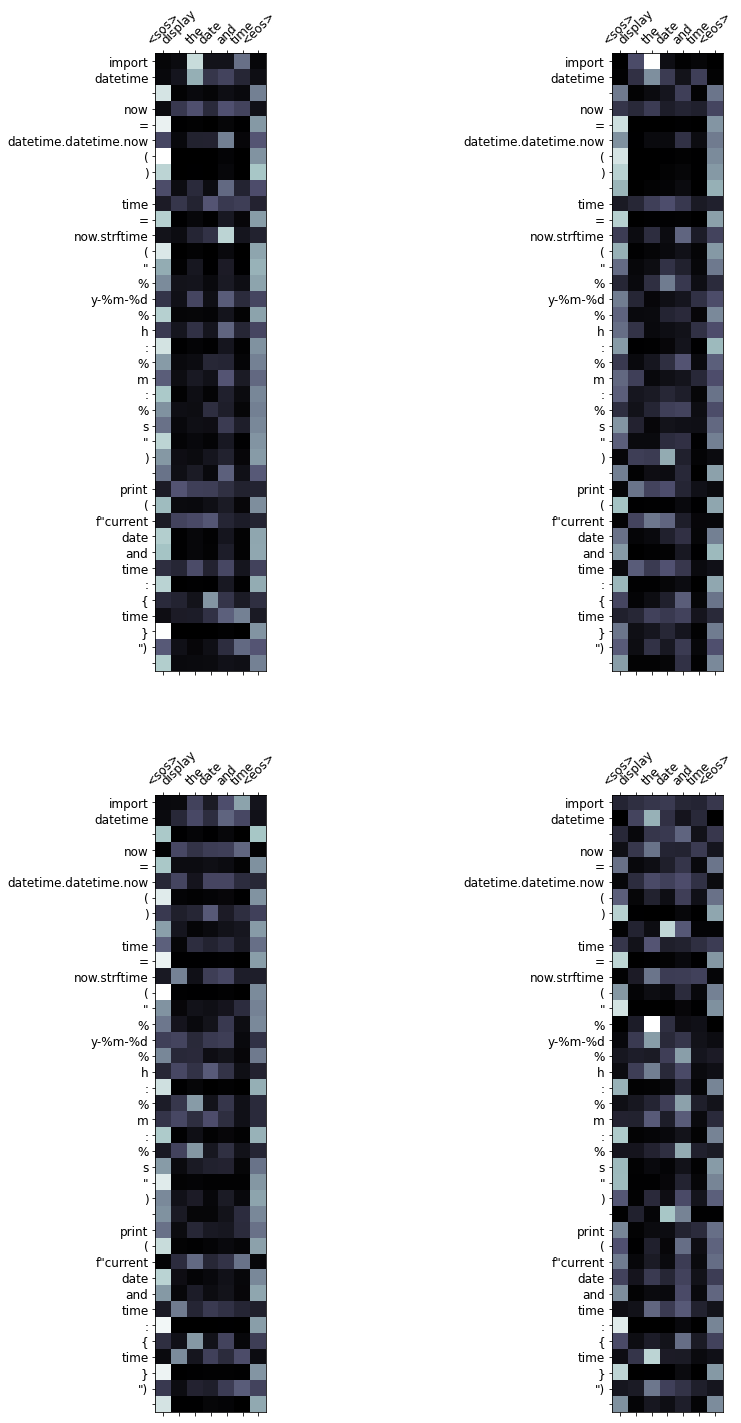


*****************************************************************
['write', 'a', 'function', 'to', 'reverse', 'a', 'list']
Write a function to reverse a list
*****************************************************************
 def reverse_list ( l1 : list ) - > list : 
     return l1[::- 1 ]


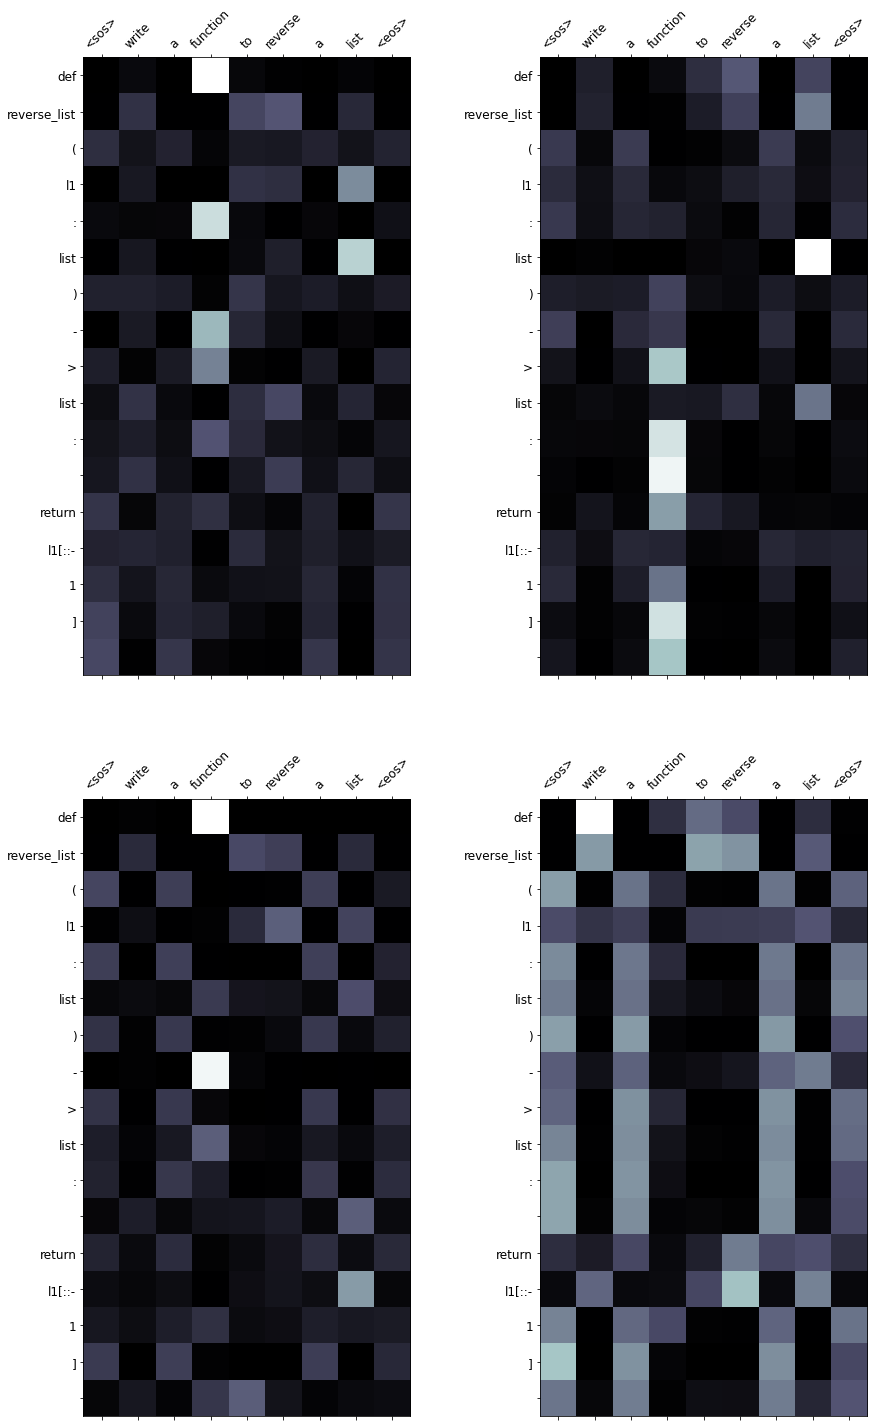


*****************************************************************
['write', 'a', 'function', 'to', 'find', 'the', 'factorial', 'of', 'n']
Write a function to find the factorial of n
*****************************************************************
 def fact ( n ): 
    if n = = 1 : 
       return n 
    else : 
       return n * fact ( n- 1 )


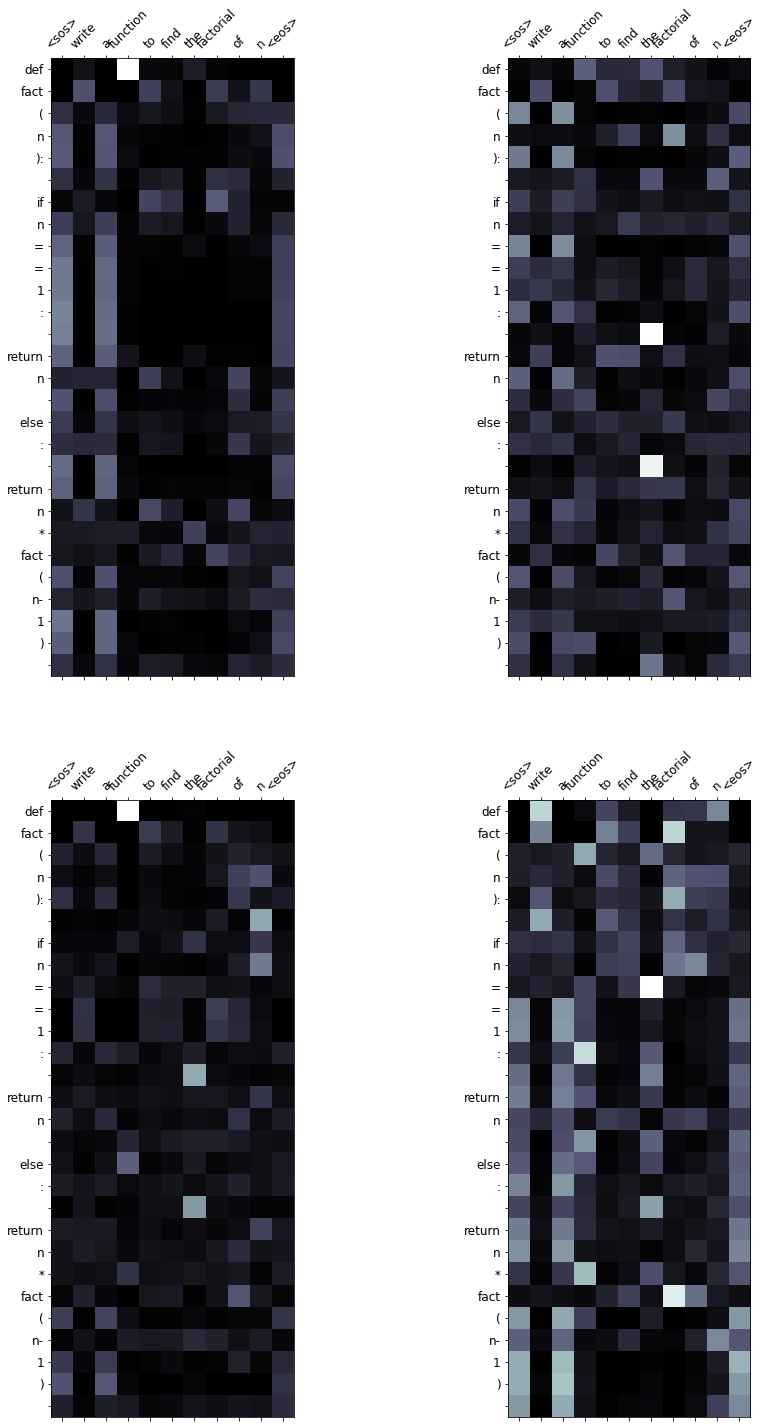


*****************************************************************
['check', 'if', 'the', 'number', 'is', 'a', 'perfect', 'square']
Check if the number is a perfect square
*****************************************************************
 num = 7 
 num_sqrt = num * * 0.5 
 print ( ' the square root of % 0.3f is % 0.3f'% ( num , num_sqrt ) )


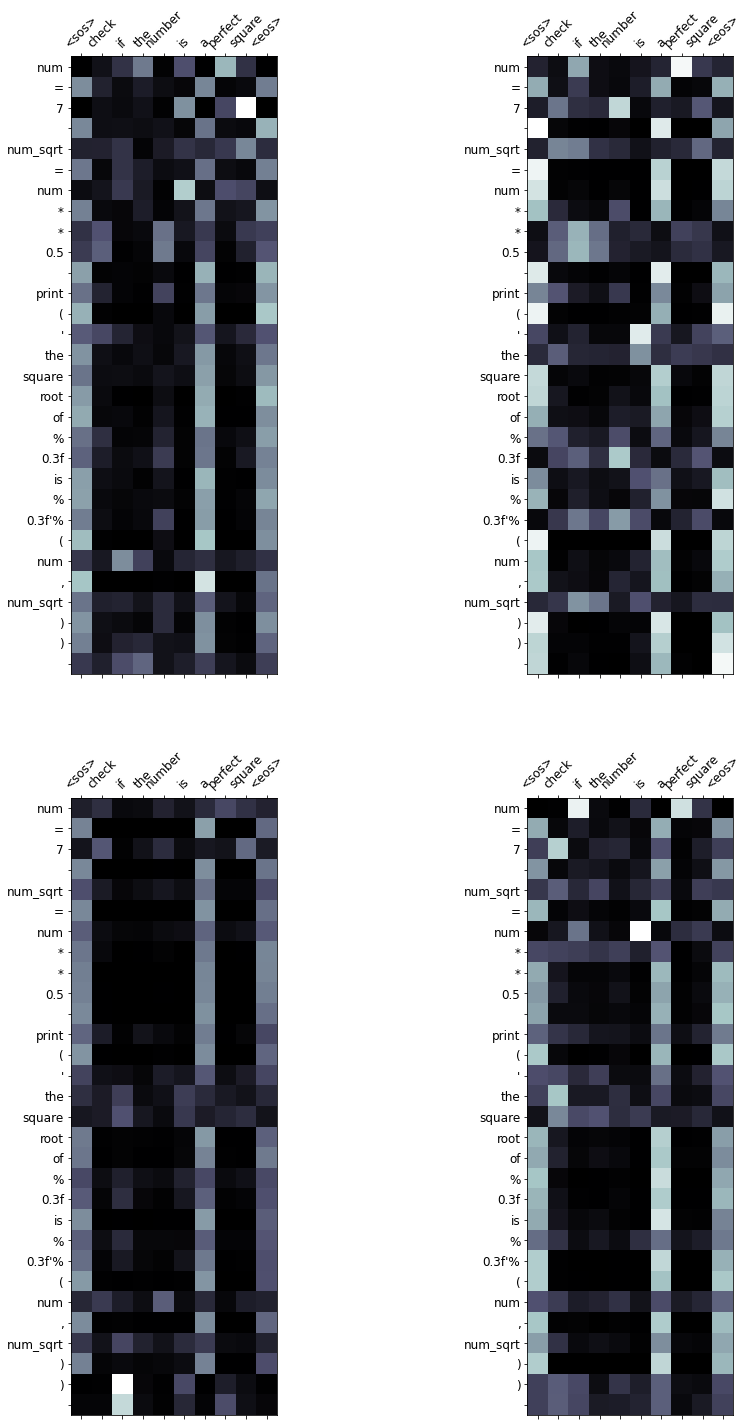


*****************************************************************
['find', 'a', 'number', 'in', 'the', 'list', 'that', 'does', 'not', 'occur', 'twice']
Find a number in the list that does not occur twice
*****************************************************************
 arr = [ 0 , 4 , 1 , 2 , 3 , 4 , 5 , 6 , 7 ] 
 result = 0 
 for i in arr : 
     print ( " result )


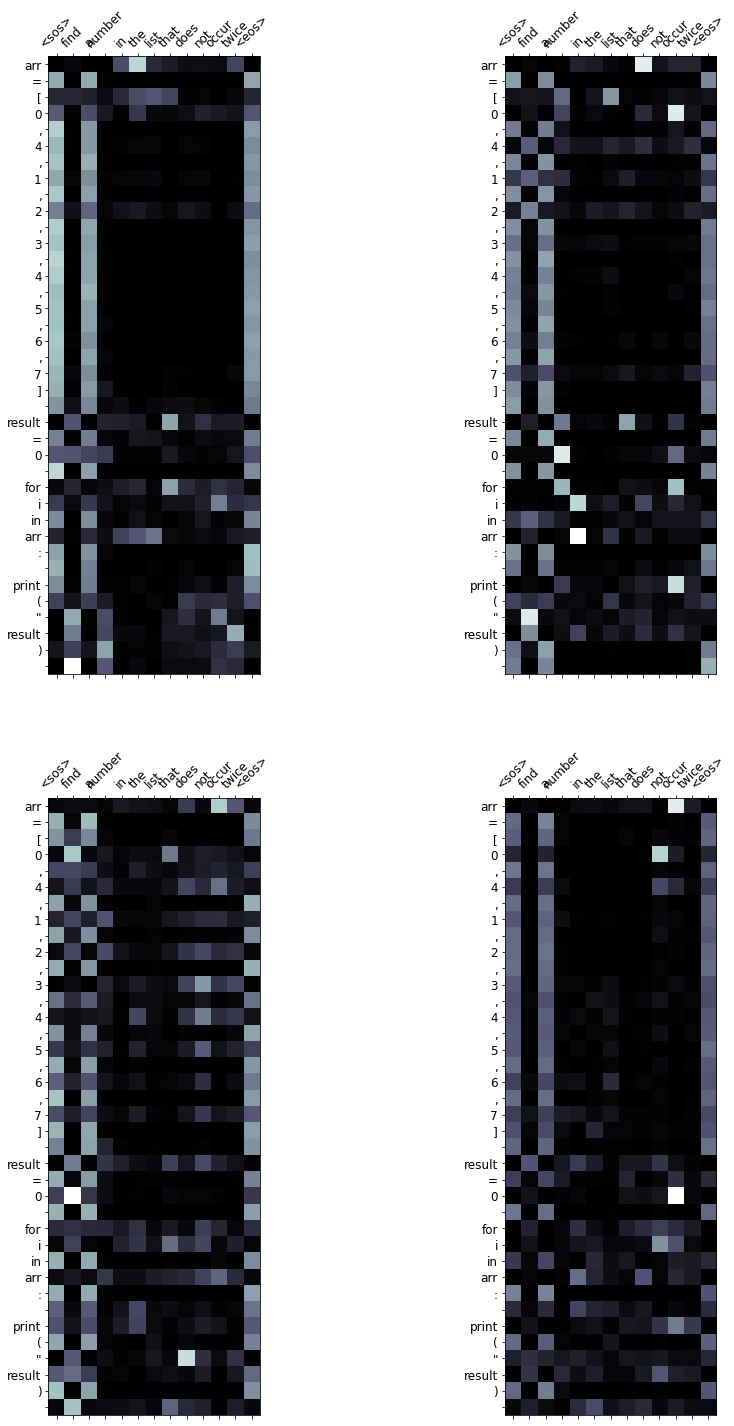


*****************************************************************
['write', 'a', 'function', 'to', 'print', 'the', 'current', 'time', 'in', 'milliseconds']
Write a function to print the current time in milliseconds
*****************************************************************
 def current_time ( ): 
     import datetime 
     print ( datetime.datetime.now ( ) )


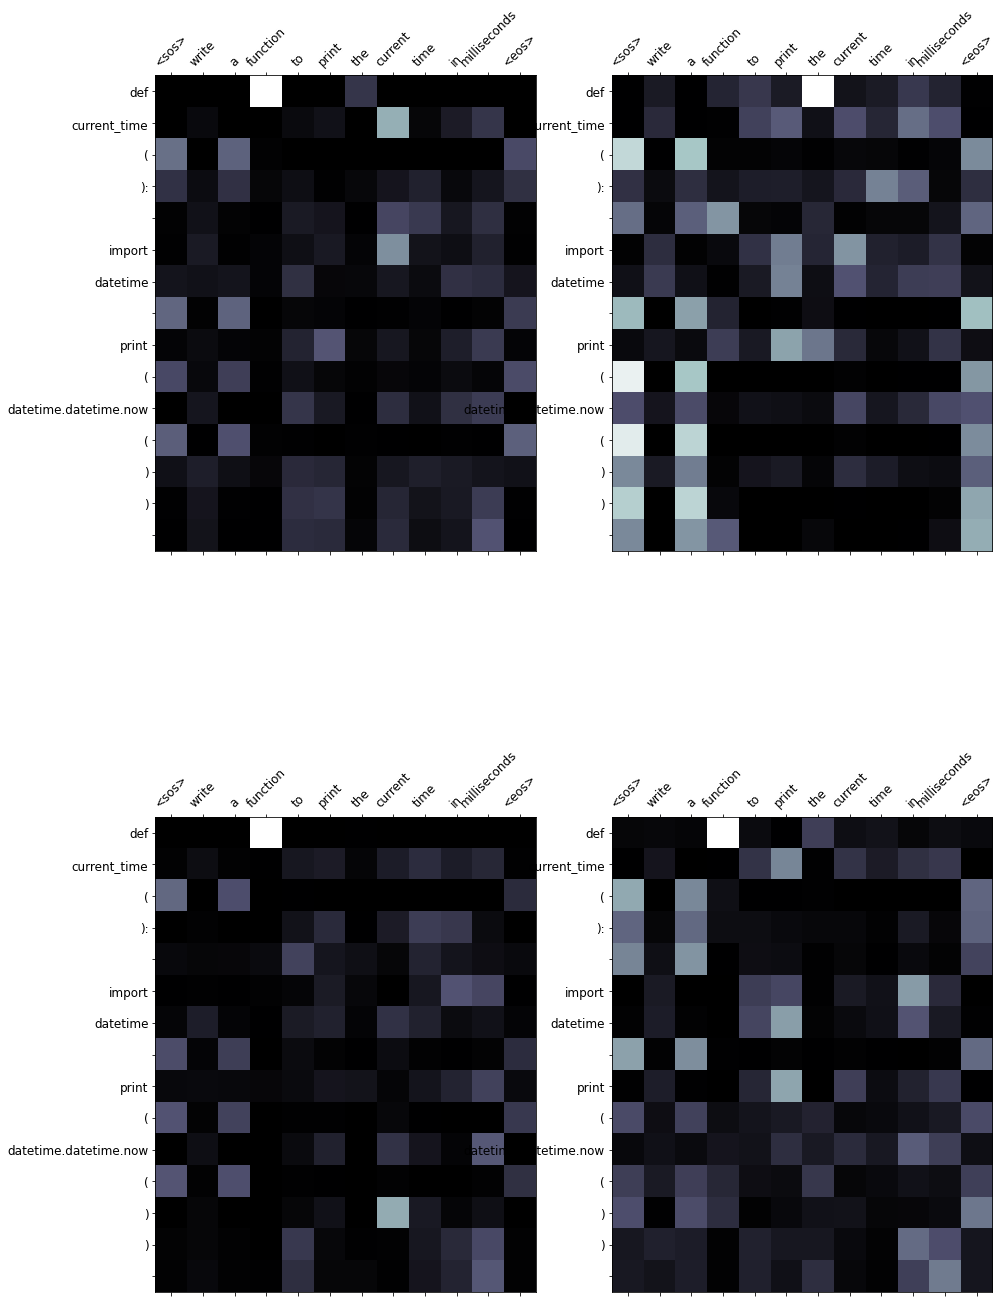


*****************************************************************
['write', 'a', 'function', 'to', 'print', 'a', 'matrix', 'as', 'output']
write a function to print a matrix as output
*****************************************************************
 def print_identity_matrix ( n ): 
     for i in range ( 0 , n ): 
         for j in range ( 0 , n ): 
             if ( i = = = = = = = = = = = = = = = = 1 ): 
                 print ( " , sep [ i ] , end = " ") 
             else : 
                 print ( )


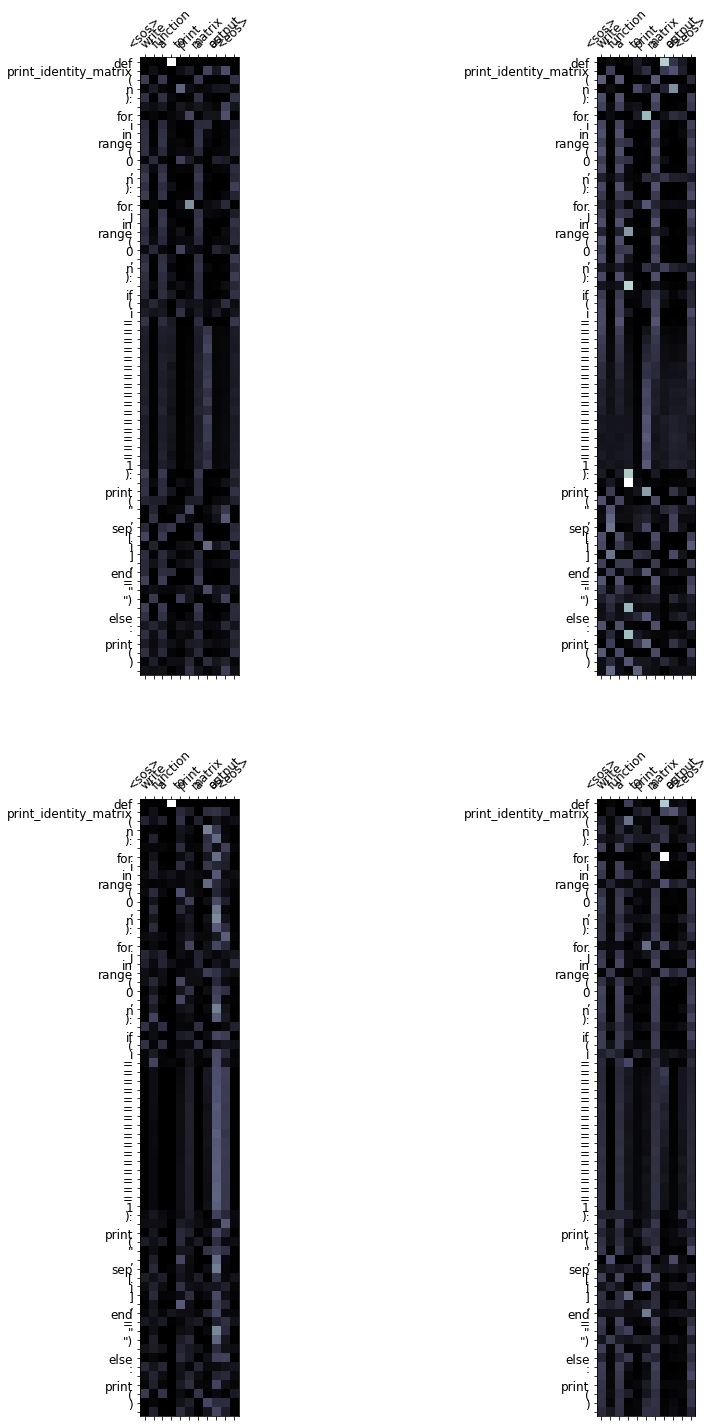


*****************************************************************
['print', 'a', 'sentence', 'into', 'lower', 'case']
Print a sentence into lower case
*****************************************************************
 s = " kilometer " 
 words = s.split ( ) 
 print ( " upper case " , " lower case " , " )


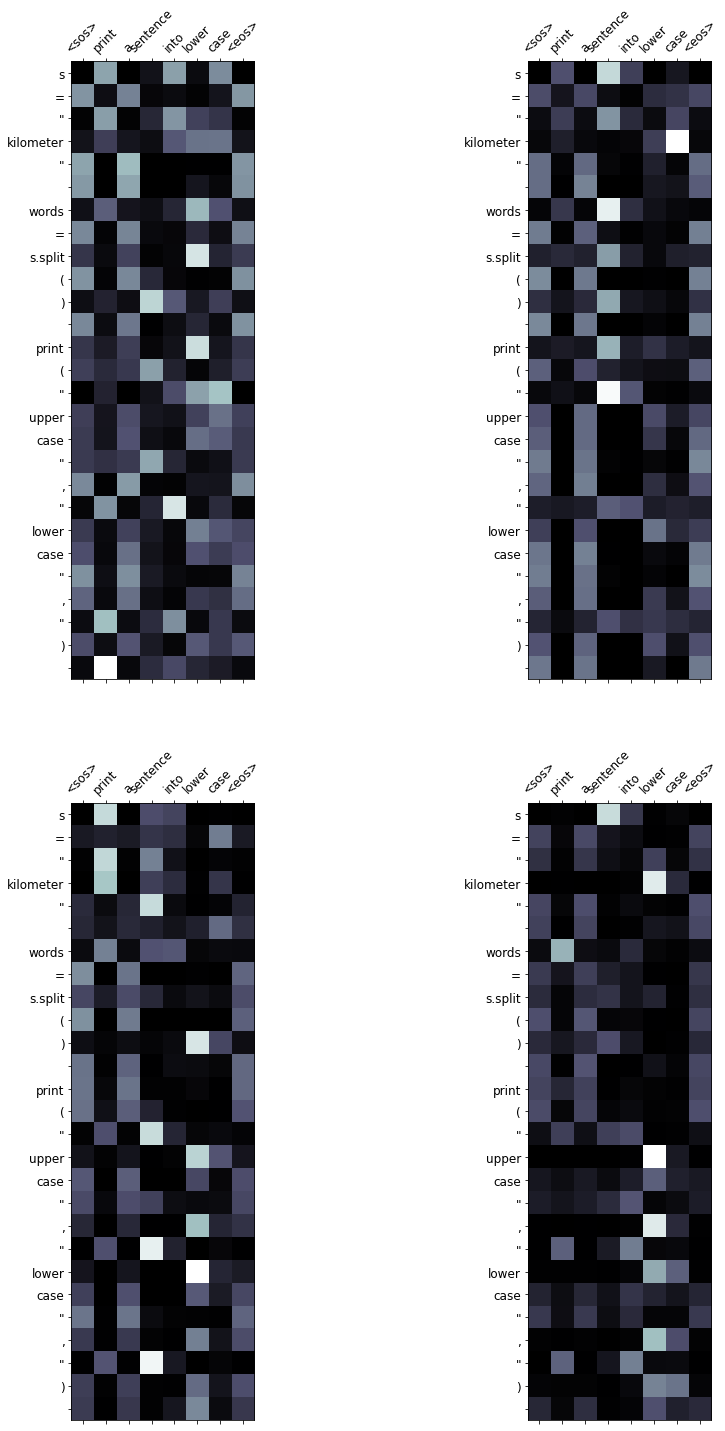


*****************************************************************
['write', 'a', 'function', 'to', 'add', 'two', 'matrices']
write a function to add two matrices
*****************************************************************
 def add_two_lists ( list_1 , list_2 ): 
     return dict ( map ( ' , ' ) )


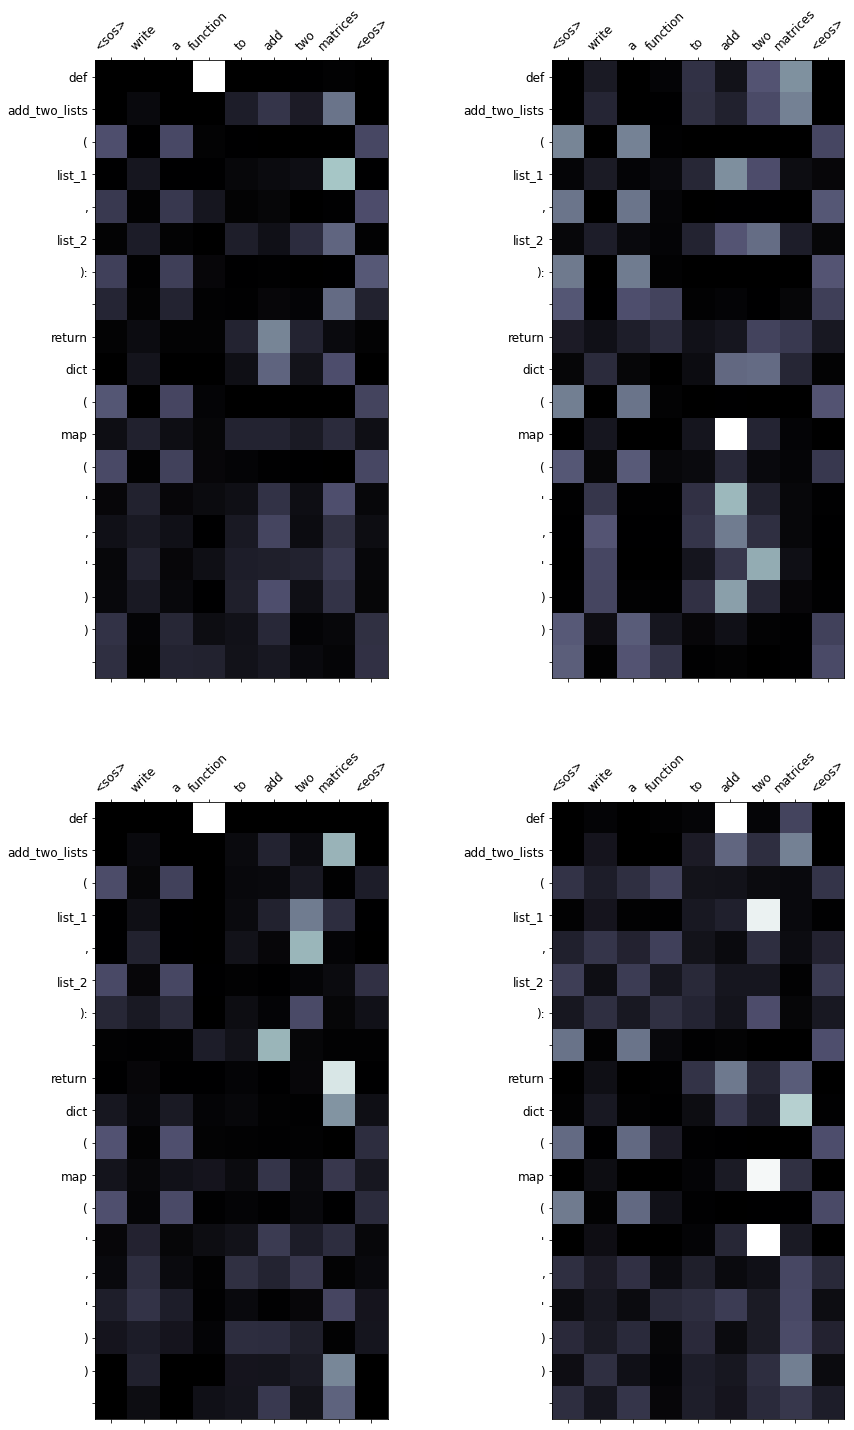


*****************************************************************
['write', 'a', 'program', 'to', 'count', 'number', 'of', 'cpu', 'cores', 'available']
write a program to count number of cpu cores available
*****************************************************************
 import os 
 os.cpu_count ( ) 
 count = 0 
 for char in ip_str : 
     count = count + 1 
 print ( count )


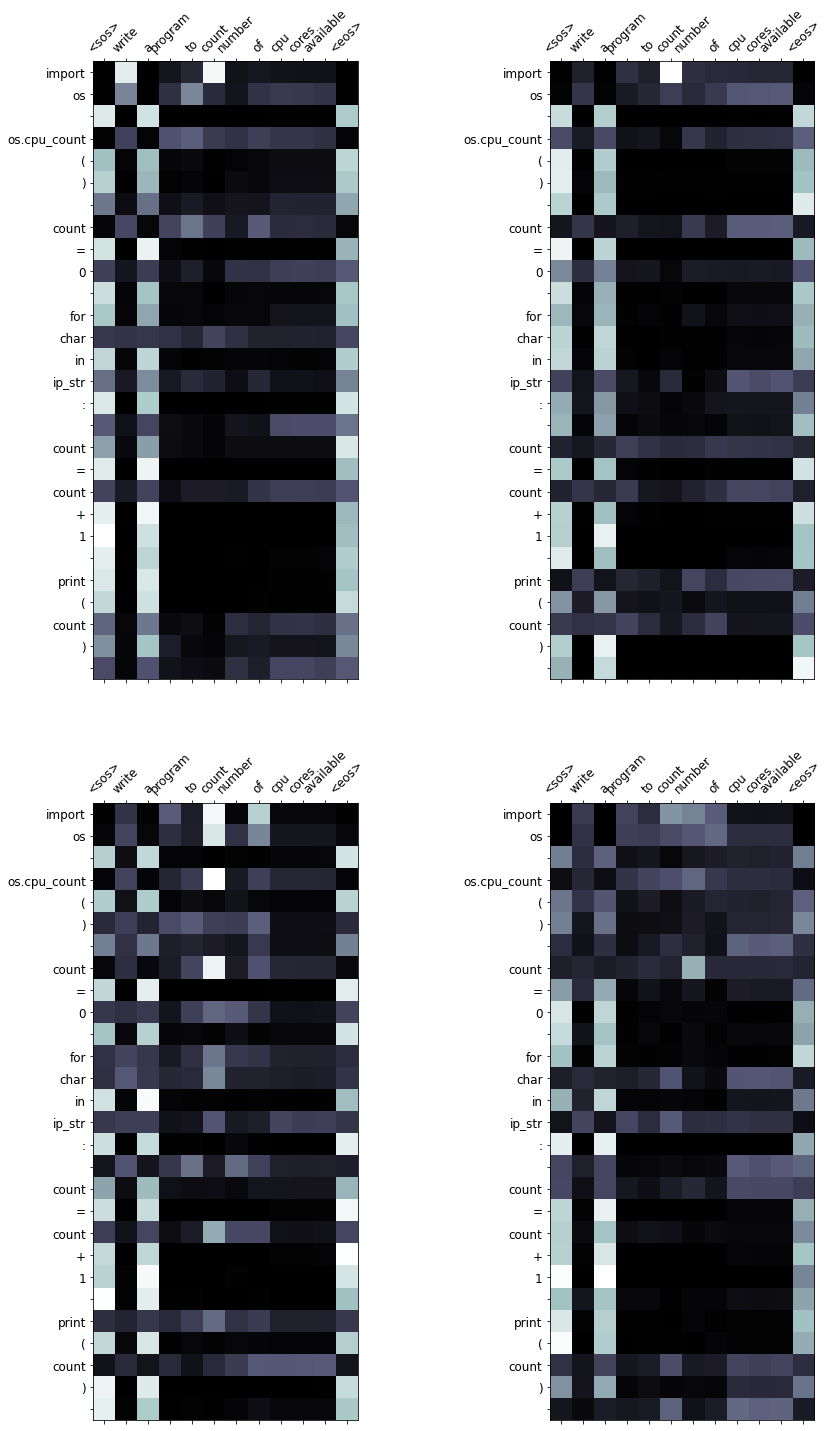


*****************************************************************
['write', 'a', 'python', 'function', 'to', 'flatten', 'nested', 'lists']
write a python function to flatten nested lists
*****************************************************************
 def flatten ( iterable ): 
     from itertools import chain 
     return chain.from_iterable ( iterable )


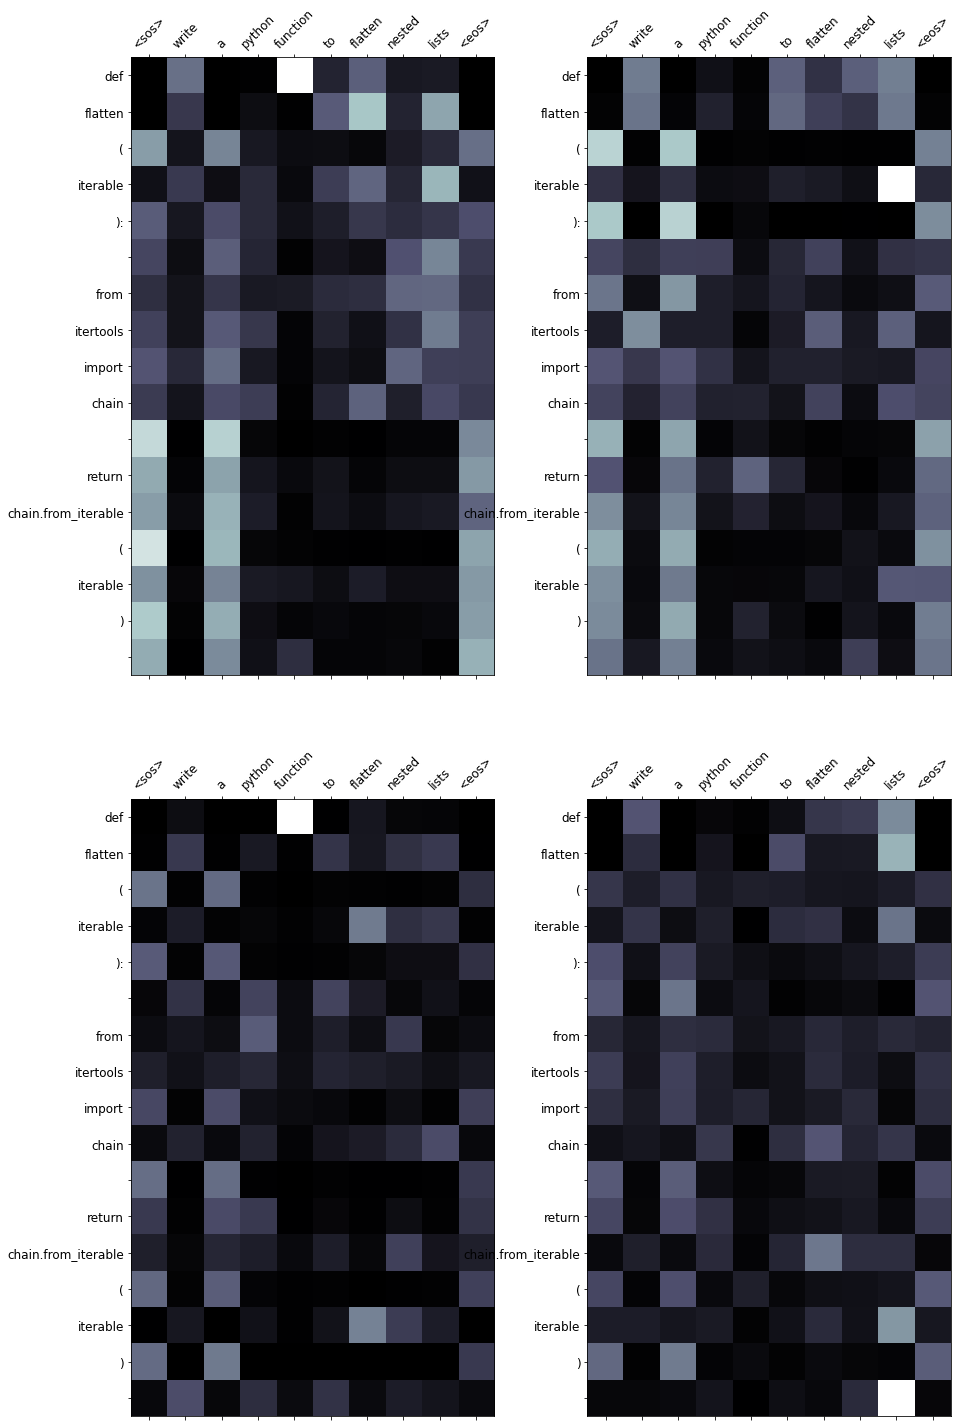


*****************************************************************
['remove', 'integer', 'from', 'string', 'in', 'python']
remove integer from string in python
*****************************************************************
 s = ' 12abcd405 ' 
 result = ' ' ' ' .join ( [ i for i in s if not i.isdigit ( ) ] )


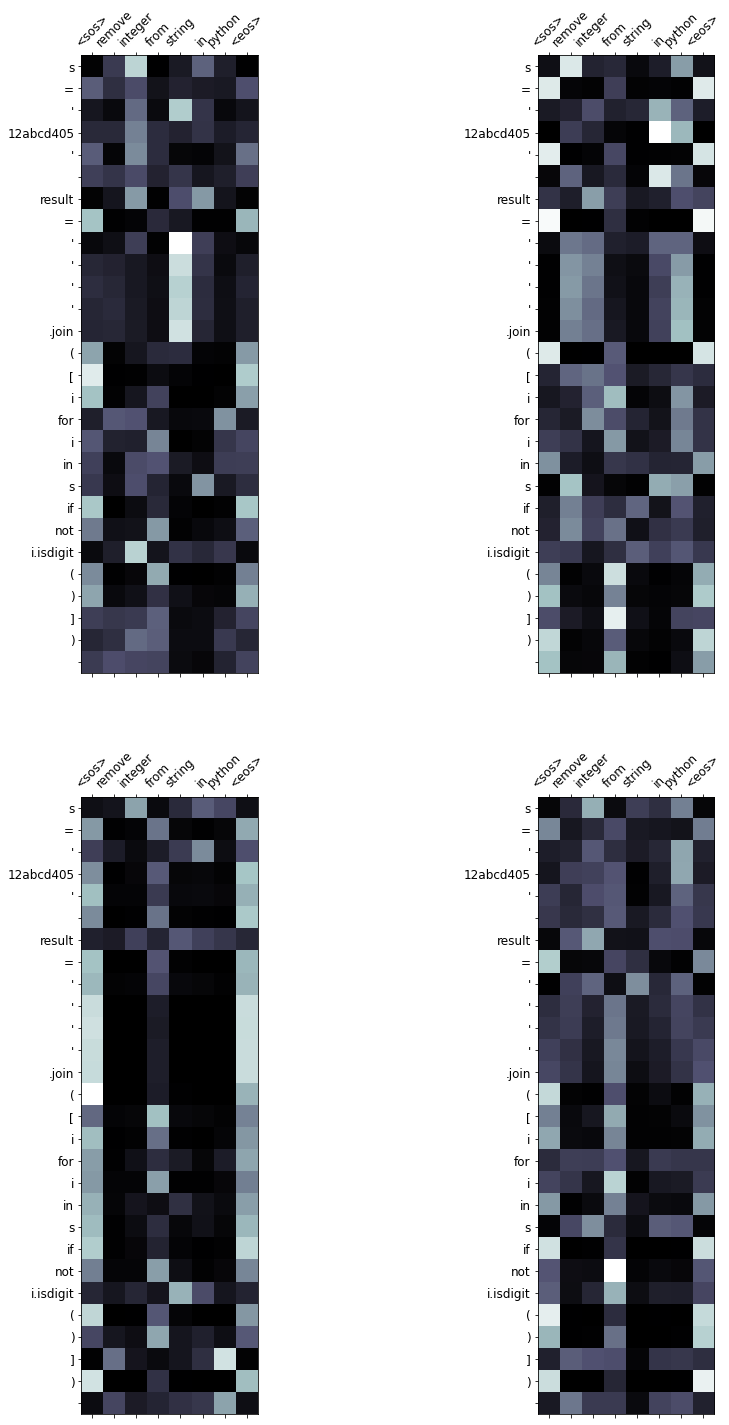


*****************************************************************
['write', 'a', 'python', 'function', 'to', 'find', 'the', 'median', 'on', 'an', 'array', 'of', 'numbers']
write a python function to find the median on an array of numbers
*****************************************************************
 def median ( arr ): 
   if len ( arr ) = = 1 : 
     return arr [ 0 ] 
   else : 
     arr = arr [ 0 ] 
     arr [ len ( arr ) / 2 ) / 2


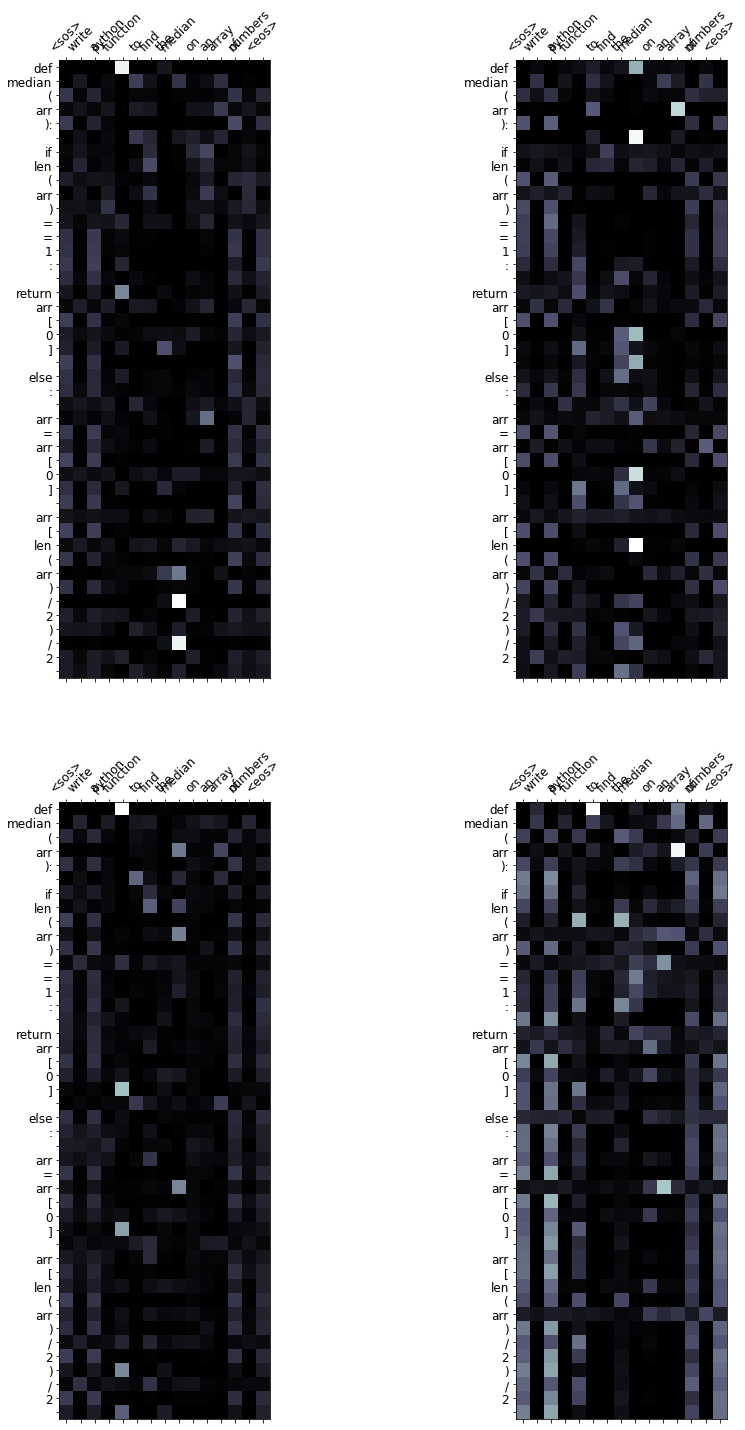


*****************************************************************
['write', 'a', 'python', 'function', 'to', 'check', 'if', 'a', 'given', 'string', 'is', 'an', 'anagram', 'of', 'another', 'given', 'string']
Write a Python function to check if a given string is an anagram of another given string
*****************************************************************
 def is_anagram ( str1 , str2 ): 
     list_str1 = list ( str1 ) 
     list_str1.sort ( str2 ) 
     list_str2 = list ( str2 ) 
     list_str2.sort ( ) 
     return ( list_str1 = list_str2 )


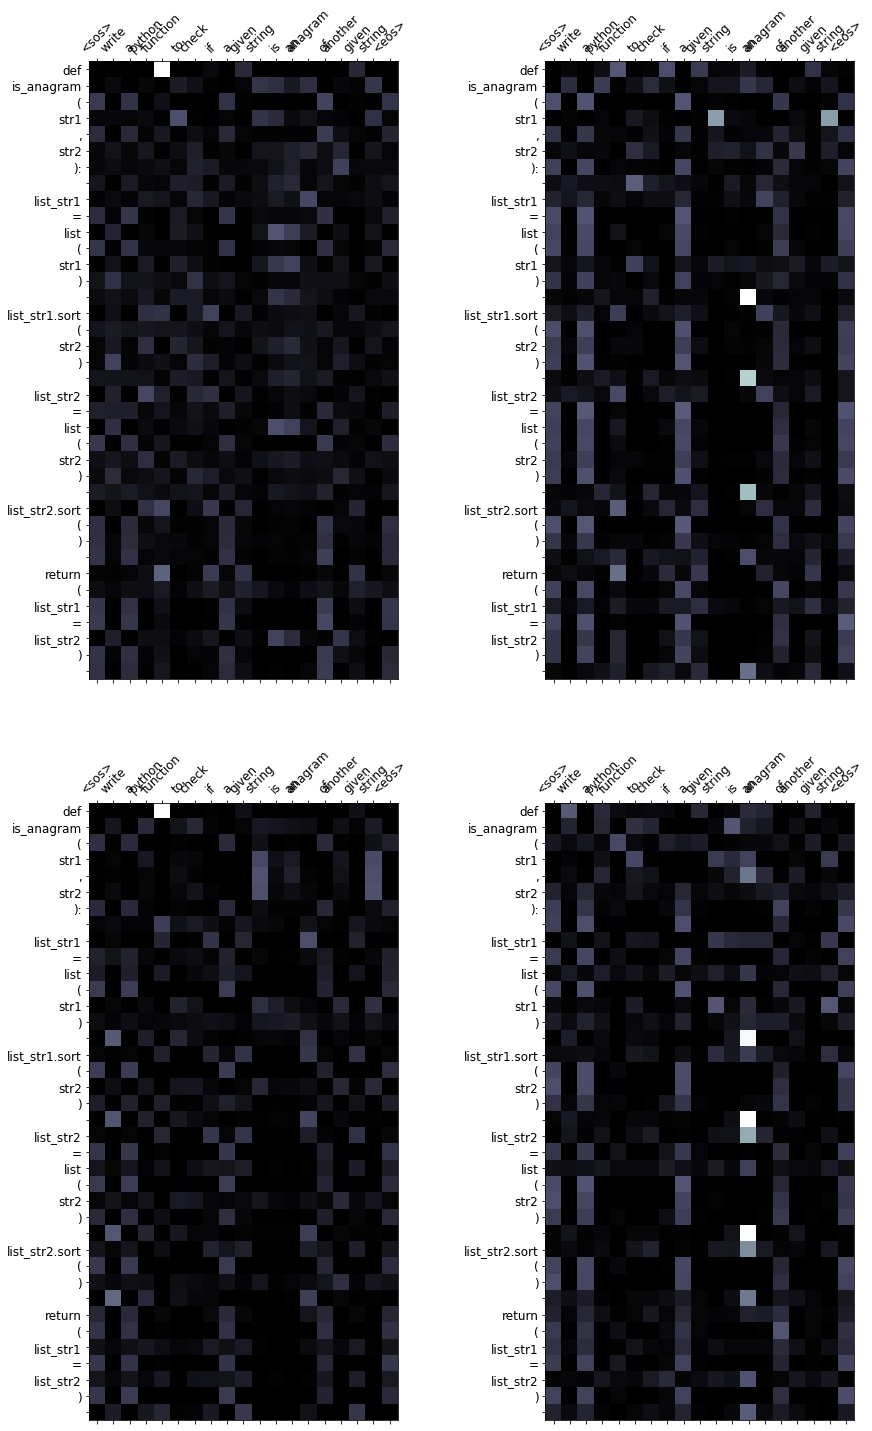


*****************************************************************
['check', 'if', 'a', 'string', 'is', 'a', 'palindrome', 'or', 'not']
Check if a string is a palindrome or not
*****************************************************************
 def reverse_string ( string ): 
     return string [ : : - 1 ] 
 print ( string )


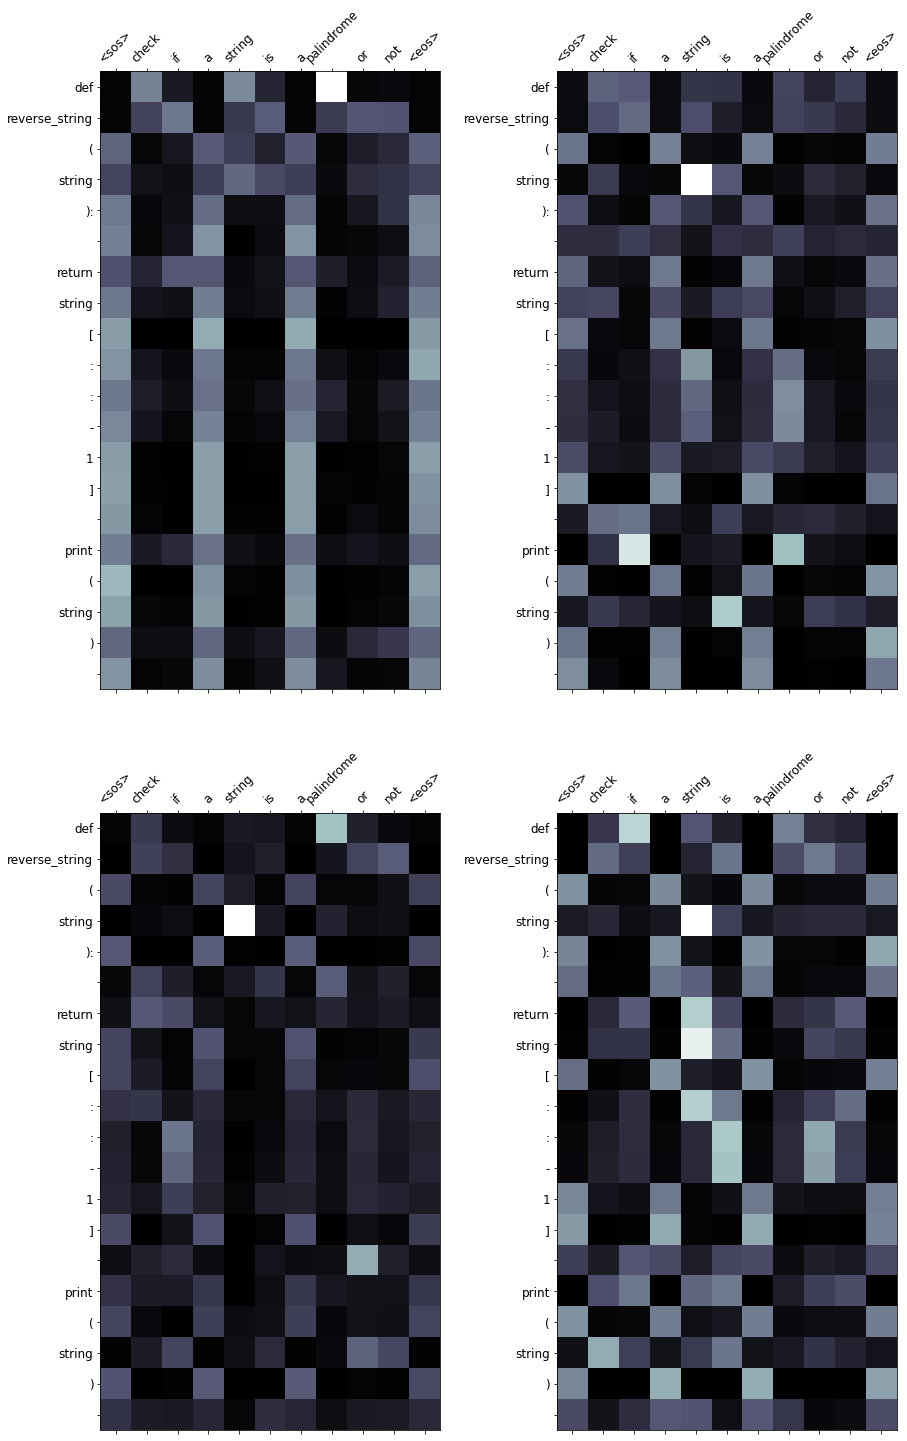


*****************************************************************
['write', 'a', 'function', 'to', 'find', 'the', 'fibonacci', 'series', 'of', 'n']
Write a function to find the fibonacci series of n
*****************************************************************
 def fibonacci ( n , m ): 
     a = 1 
     b = 1 
     if n < = 0 : 
         return n 
     else : 
         return n + a


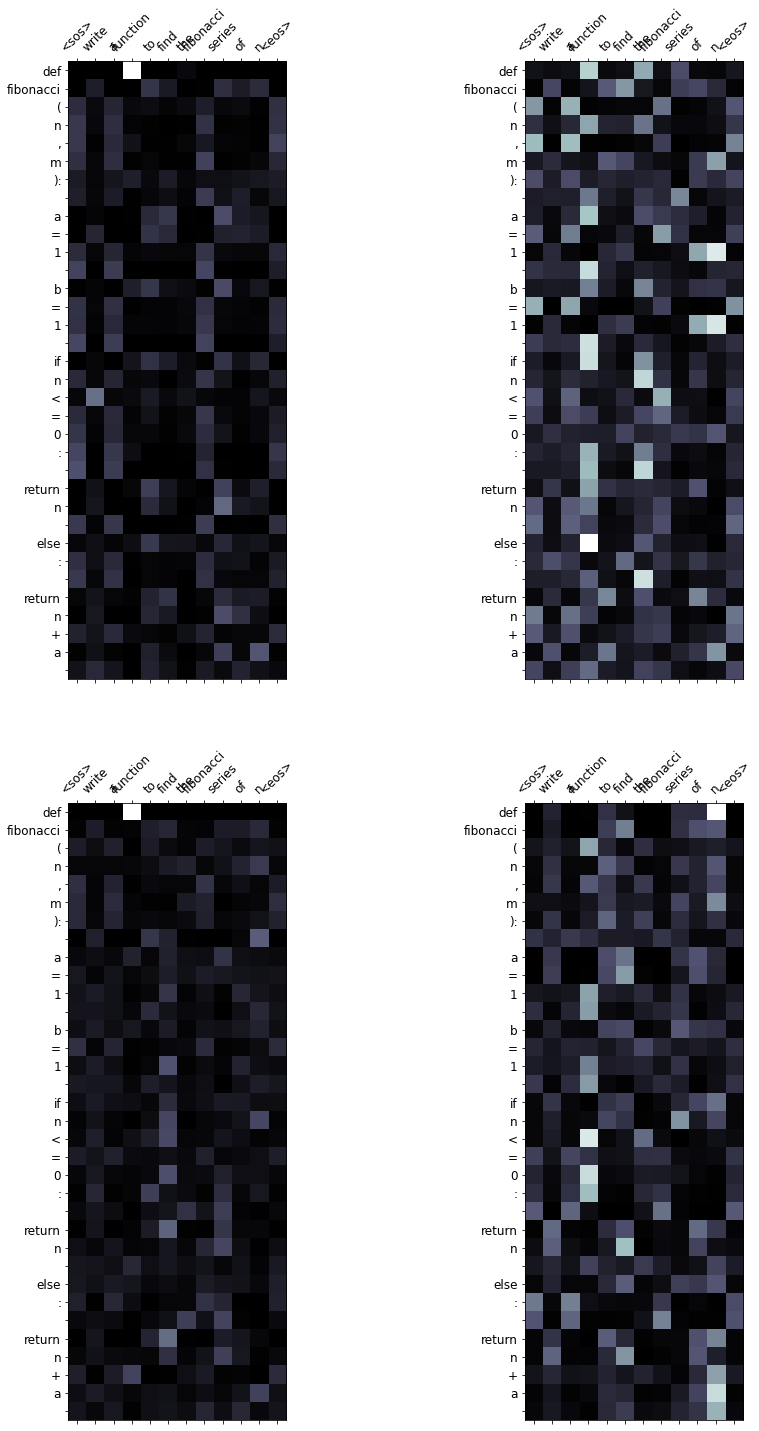


*****************************************************************
['write', 'a', 'function', 'to', 'calculate', 'the', 'area', 'of', 'a', 'circle']
Write a function to calculate the area of a circle
*****************************************************************
 def findarea ( r ): 
     pi = 3.142 
     return pi * ( r * r )


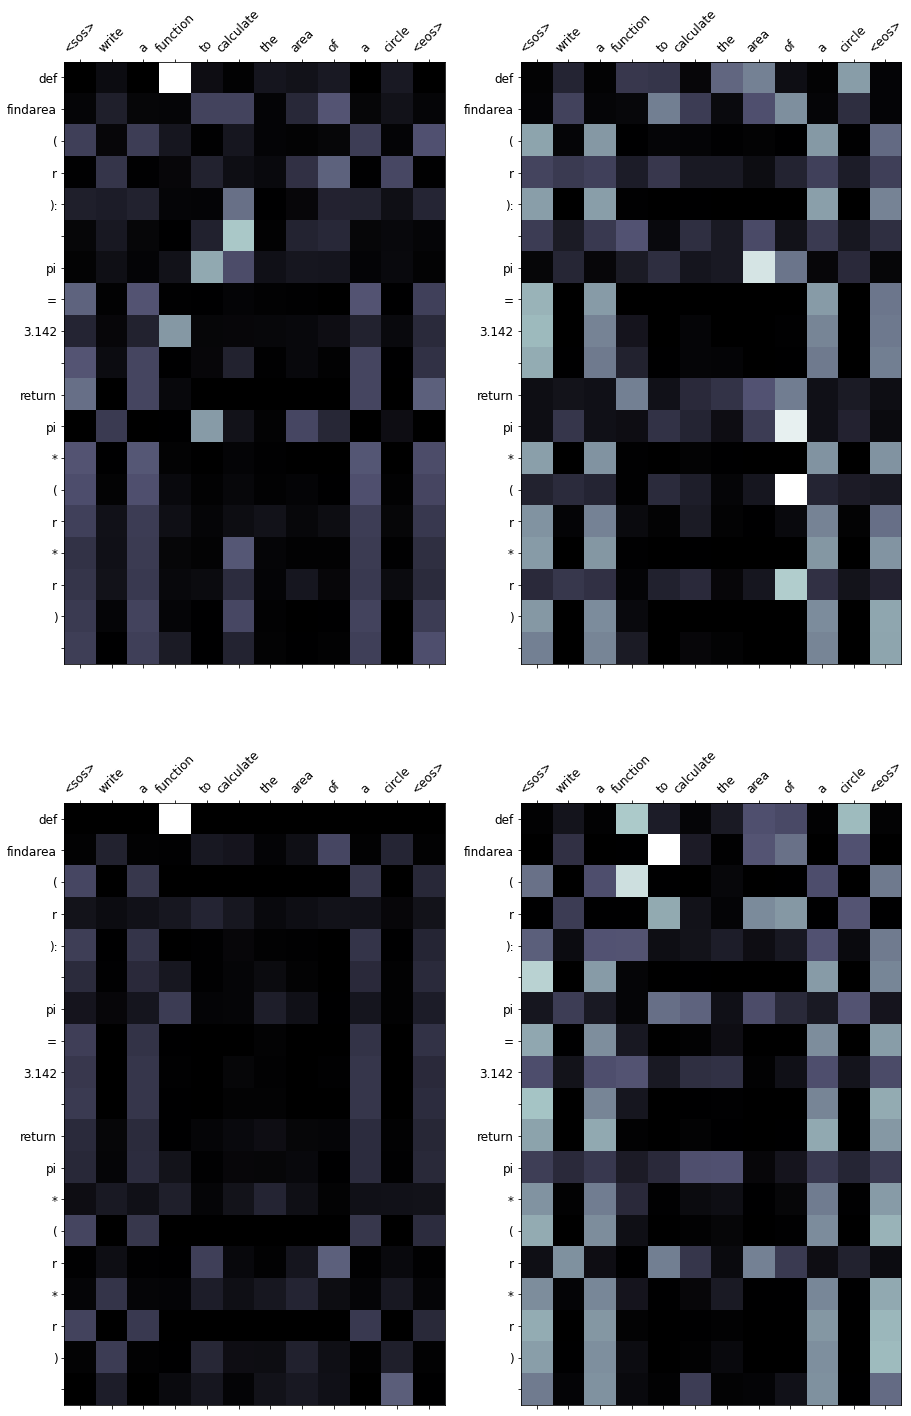


*****************************************************************
['write', 'a', 'python', 'program', 'to', 'find', 'the', 'smallest', 'multiple', 'of', 'the', 'first', 'n', 'numbers']
Write a Python program to find the smallest multiple of the first n numbers
*****************************************************************
 n = 10 
 sum = 0 
 i = 1 
 while i < 10 
 n : 
     if n < = = = = = = 0 : 
         curr + 1 
     return n


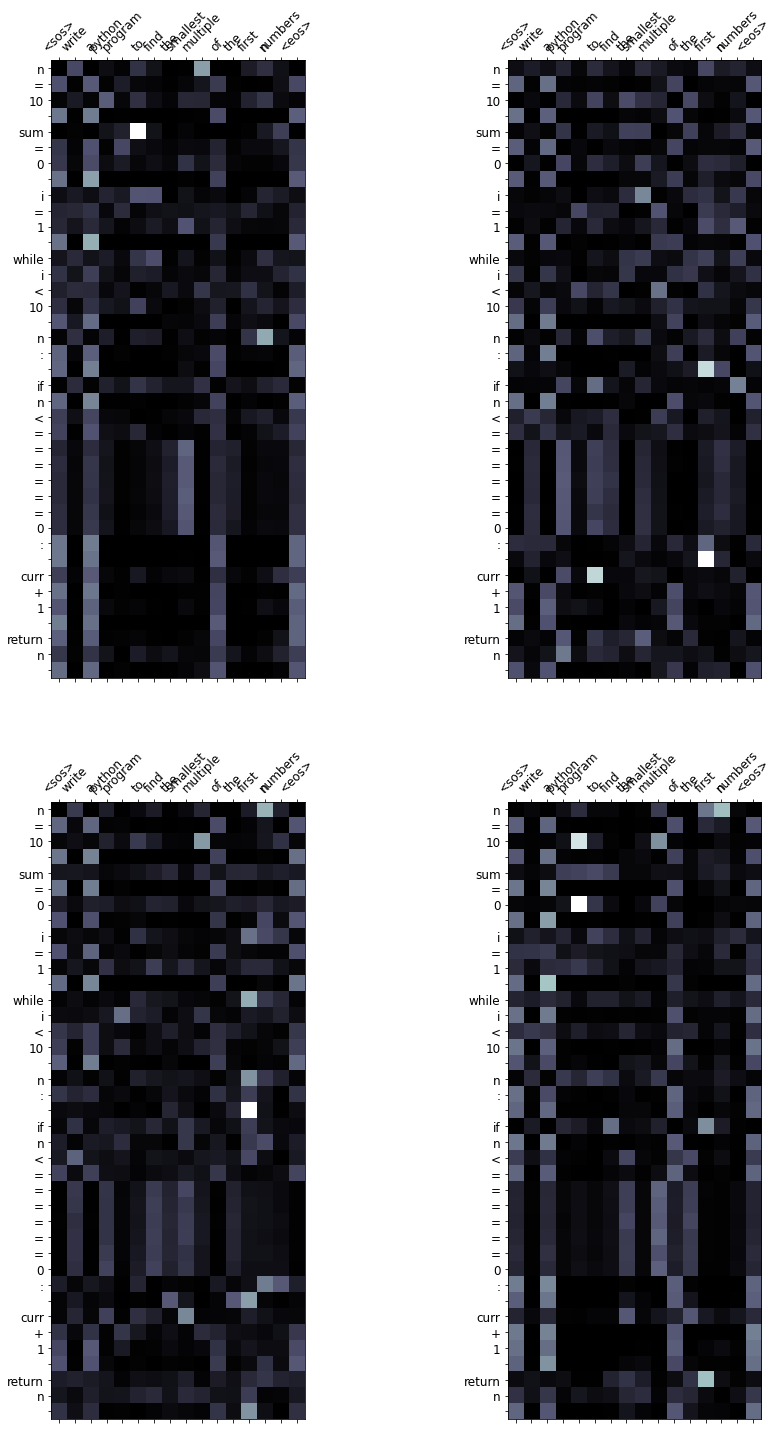


*****************************************************************
['write', 'a', 'python', 'function', 'to', 'find', 'the', 'maximum', 'even', 'number', 'from', 'a', 'given', 'list']
Write a Python function to find the maximum EVEN number from a given list
*****************************************************************
 def even_max_checker ( list1 ): 
	 maxnum = 0 
	 for num in list1 : 
	     if num% 2 = num > maxnum : 
	             maxnum = num 
	 return maxnum


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


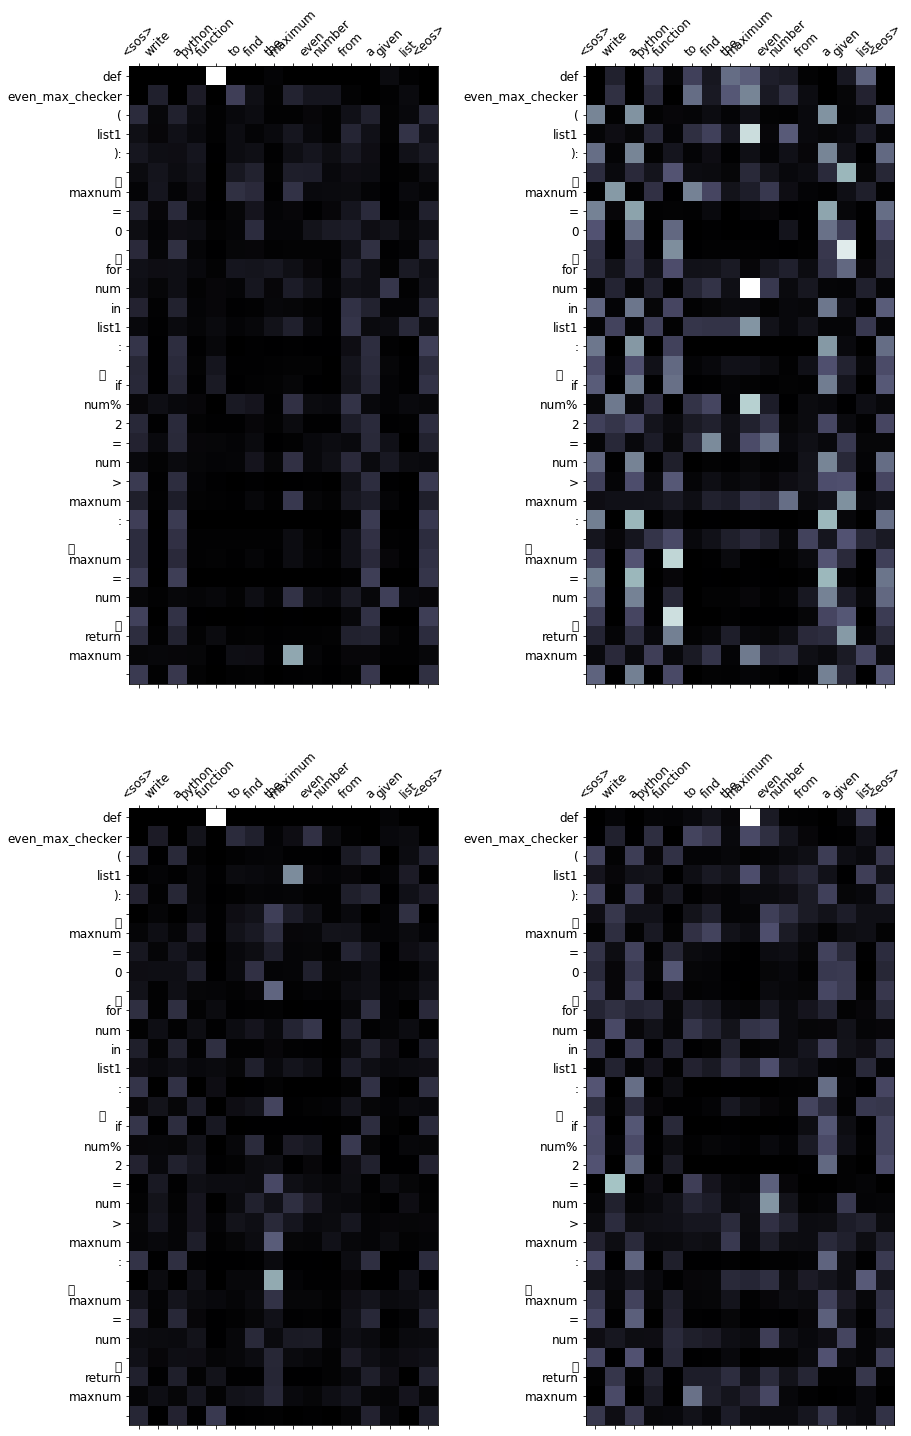


*****************************************************************
['write', 'a', 'python', 'function', 'to', 'convert', 'a', 'string', 'to', 'upper', 'case']
Write a python function to convert a string to upper case
*****************************************************************
 def string_opertaion ( st ): 
     st = st.lower ( ) 
     for i in range ( 1 , n ): 
         if ( i % i = = = = 0 ) : 
             return false 
     return true


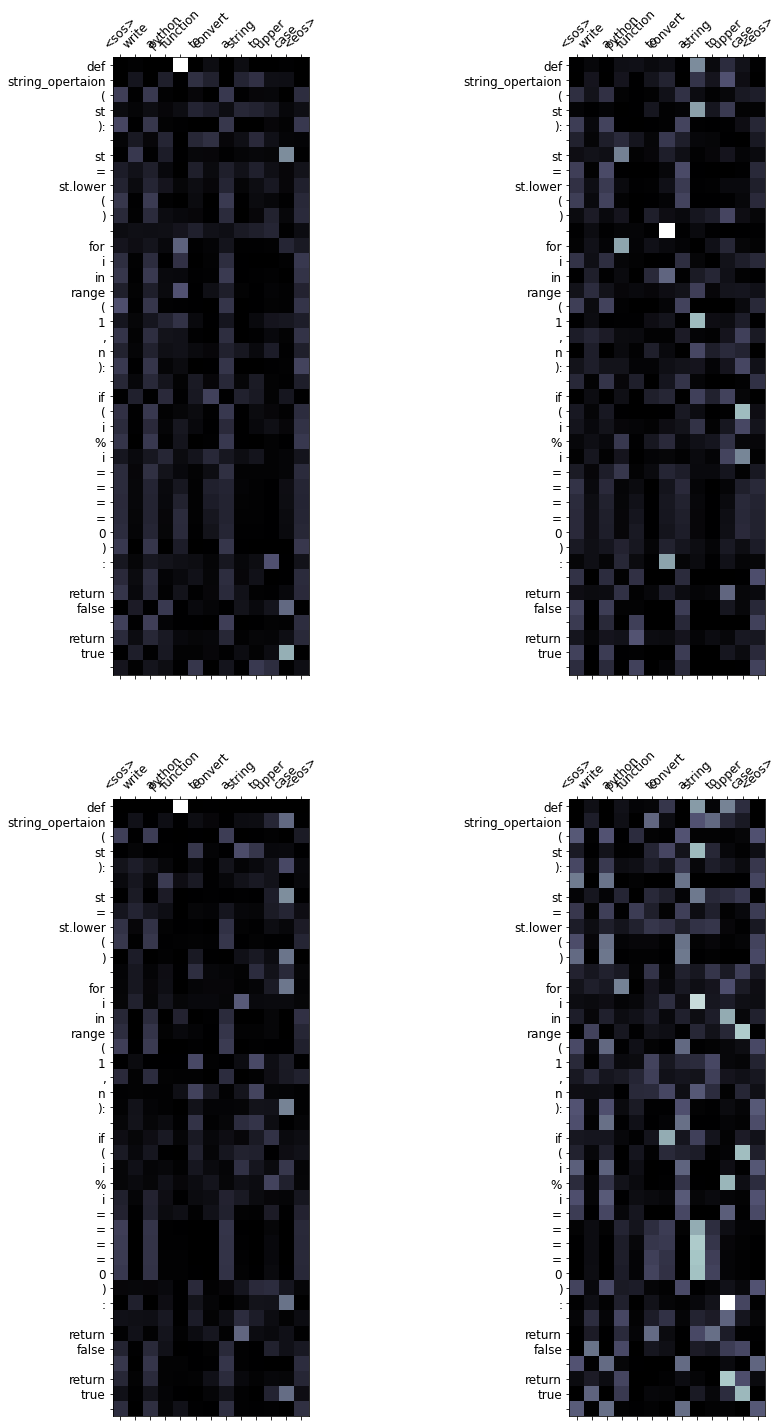


*****************************************************************
['write', 'a', 'python', 'program', 'to', 'print', 'current', 'time', 'in', 'milliseconds']
Write a Python program to print current time in milliseconds
*****************************************************************
 import time 
 milliseconds = int ( round ( time.time ( ) * 1000 ) ) 
 print ( milliseconds )


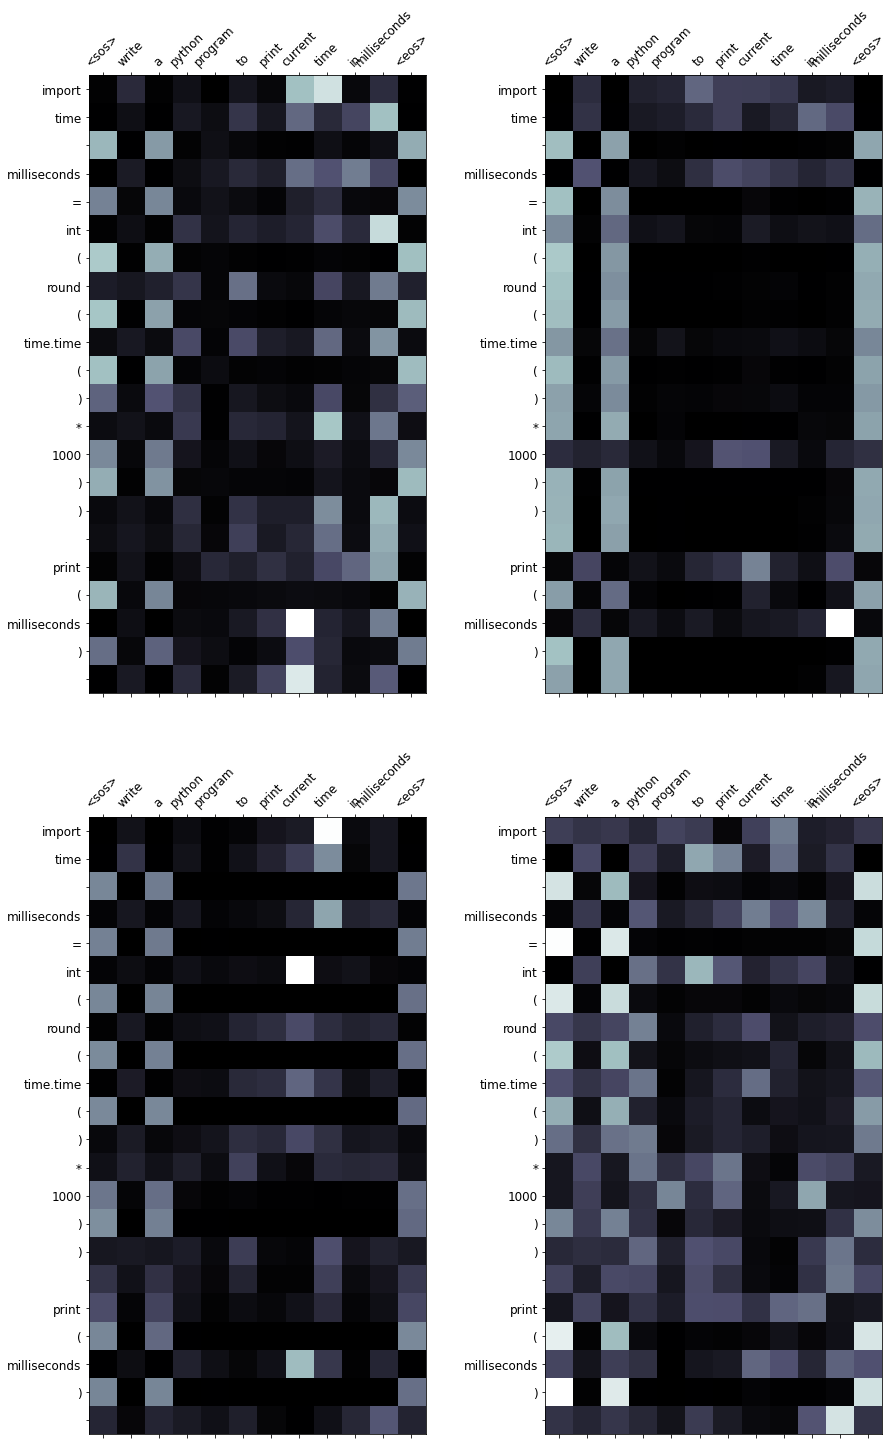

In [73]:
model.load_state_dict(torch.load('model.pt'))

for question in inference_questions:
    print("\n*****************************************************************")
    output_words, attention = generate_words(question, src, trg, model, device, max_length=250)
    # Format and print response sentence
    output_words[:] = [x for x in output_words if not (x == '<eos>' or x == '<pad>' or x == '<unk>')]
    # print(output_words)
    # print('Bot:\n', ' '.join(output_words))
    code_generated = ' '.join(output_words)
    print(question + '\n*****************************************************************\n', 
          code_generated)
    display_attention(tokenize_en(question), output_words, attention, 4, 2, 2)


### **Evaluation metrics**

In [74]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 250):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        # print("Source: ", src)
        # print("Target: ", trg)
        pred_trg, _ = generate_words(src, src_field, trg_field, model, device, max_len)
        # print("Predicted: ", pred_trg)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score_test = calculate_bleu(test_data, src, trg, model, device)
print(bleu_score_test)